# **Projet 9: Réalisez une application de recommandation de contenu**

## **SOMMAIRE**

1.  **Préparation et configuration de l'espace de travail**
2.  **Chargement et exploration des données (EDA)**
3.  **Visualisation des Embeddings avec t-SNE**
4.  **Préparation des données pour la modélisation**
5.  **Définition des Classes de Modèles**
6.  **Définition du Cadre d'Évaluation (`ModelEvaluator`)**
7.  **Entraînement et Évaluation des Modèles**
8.  **Optimisation des Hyperparamètres et du Modèle Hybride**
9.  **Sauvegarde et Analyse du Modèle Final**
10. **Mise à Jour Périodique du Modèle (Retraining)**

## **1. Préparation et configuration de l'espace de travail**

### **Connexion à Google Drive et Installation des librairies**
Cette cellule monte le Google Drive (si utilisé) et installe les bibliothèques nécessaires à partir du fichier `requirements.txt`. `surprise` et `implicit` sont des bibliothèques spécialisées pour les systèmes de recommandation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -r "/content/drive/MyDrive/P9_recommandation-contenu/requirements_model.txt"

### **Importation des librairies**
Nous importons toutes les bibliothèques que nous utiliserons tout au long du notebook.

In [ ]:
!pip install mlflow

In [ ]:
# Importations de base
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import random
import pickle

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Recommandation
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

# Librairies spécialisées en recommandation
from scipy.sparse import csr_matrix
import implicit
from surprise import Reader, Dataset, SVD, SVDpp, KNNWithMeans
from surprise.model_selection import GridSearchCV

# MLflow pour le suivi des expériences
import mlflow
import mlflow.pyfunc

# Pour un affichage plus propre dans le notebook
from IPython.display import display, HTML

### **Définition des chemins**
Cette section configure les chemins vers les fichiers de données.

In [ ]:
# Définition de l'emplacement du projet (à ajuster si nécessaire)
PROJECT_ROOT = r'/content/drive/MyDrive/P9_recommandation-contenu'
#PROJECT_ROOT = r'data'  # Utiliser le répertoire courant pour les tests locaux

## **2. Chargement et exploration des données (EDA)**

### **Chargement des données**
Nous chargeons les trois ensembles de données principaux :
1.  `articles_embeddings.pickle` : Les vecteurs de caractéristiques (embeddings) pour chaque article.
2.  `articles_metadata.csv` : Les métadonnées des articles (catégorie, date de création).
3.  `clicks` : L'historique des interactions des utilisateurs, agrégé à partir de 365 fichiers horaires.

In [ ]:
# --- 1. Chargement des Embeddings des Articles (items2vec) ---
print("Chargement des embeddings des articles (items2vec)...")
items2vec = pd.read_pickle(os.path.join(PROJECT_ROOT, 'data/articles_embeddings.pickle'))

# --- 2. Chargement des Métadonnées des Articles ---
print("Chargement des métadonnées des articles...")
items = pd.read_csv(os.path.join(PROJECT_ROOT, 'data/articles_metadata.csv'), delimiter=',')

# --- 3. Chargement et Agrégation des Données de Clics (All Clicks) ---
print("Agrégation des données de clics (365 fichiers horaires)...")
clics = pd.DataFrame()
clicks_path = os.path.join(PROJECT_ROOT, 'data/clicks', 'clicks')

if os.path.exists(clicks_path):
    for i in tqdm(range(365), desc="Traitement des fichiers de clics"):
        file_path = os.path.join(clicks_path, 'clicks_hour_'+"%03d" % i+'.csv')
        try:
            temp = pd.read_csv(file_path, delimiter=',')
            clics = pd.concat([clics, temp], ignore_index=True)
        except FileNotFoundError:
            #print(f"Avertissement : Fichier non trouvé à {file_path}. Skipping.")
            continue
    clics = clics.reset_index(drop=True)
    print(f"Chargement et agrégation terminés. Nombre total de clics : {len(clics)}")
else:
    print(f"Le dossier de clics n'a pas été trouvé à l'emplacement : {clicks_path}")

Chargement des embeddings des articles (items2vec)...
Chargement des métadonnées des articles...
Agrégation des données de clics (365 fichiers horaires)...


Traitement des fichiers de clics: 100%|██████████| 365/365 [04:27<00:00,  1.36it/s]


Chargement et agrégation terminés. Nombre total de clics : 2800725


### **Exploration et Analyse des Données (EDA)**
Nous effectuons une analyse exploratoire pour comprendre la distribution et les caractéristiques de nos données. Cette étape est fondamentale pour identifier les biais potentiels, comprendre le comportement des utilisateurs et valider la qualité des données avant de construire nos modèles.

In [ ]:
sns.set_style("whitegrid")

print("\n--- Statistiques Descriptives ---")
print("\nInformations sur le DataFrame 'clics':")
clics.info()

print("\nInformations sur le DataFrame 'items':")
items.info()

# Conversion des types de données pour 'clics'
for col in ['session_size', 'click_article_id', 'click_timestamp']:
    clics[col] = pd.to_numeric(clics[col], errors='coerce')

nb_users = clics['user_id'].nunique()
nb_articles = items['article_id'].nunique()
print(f"\nNombre d'utilisateurs uniques : {nb_users}")
print(f"Nombre d'articles uniques : {nb_articles}")
print(f"Nombre total d'interactions (clics) : {len(clics)}")


--- Statistiques Descriptives ---

Informations sur le DataFrame 'clics':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800725 entries, 0 to 2800724
Data columns (total 12 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   click_article_id     object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
dtypes: object(12)
memory usage: 256.4+ MB

Informations sur le DataFrame 'items':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 n

#### Analyse de l'Activité des Utilisateurs

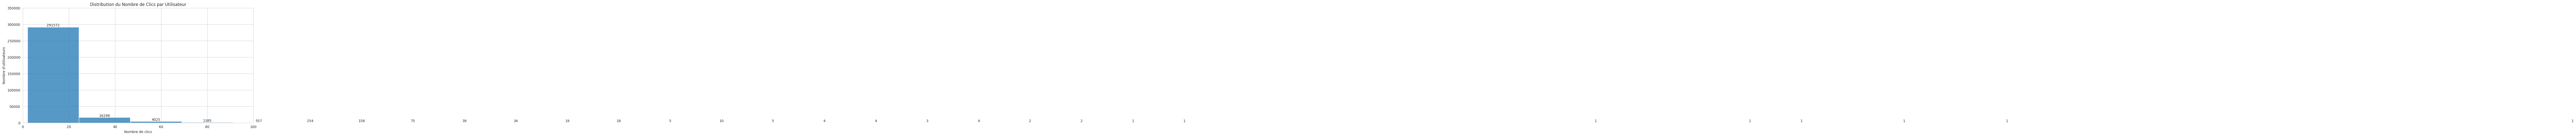

,0
count,314481.000000
mean,8.905864
std,14.067970
min,2.000000
25%,2.000000
50%,4.000000
75%,10.000000
max,1117.000000



Statistiques sur le nombre de clics par utilisateur:


In [ ]:
user_clicks = clics.groupby('user_id').size().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.histplot(user_clicks, bins=50) # Removed log_scale=(False, True)
plt.title('Distribution du Nombre de Clics par Utilisateur')
plt.xlabel('Nombre de clics')
plt.ylabel("Nombre d'utilisateurs") # Updated label
plt.xlim(0, 100) # Limit x-axis to show up to 100 clicks
plt.ylim(0, 350000) # Limit y-axis to show up to 150,000 users

# Add annotations to each bar
for patch in ax.patches:
    height = patch.get_height()
    if height > 0: # Only annotate bars with users
        ax.text(patch.get_x() + patch.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

plt.show()

display(user_clicks.describe()) # Affiche les statistiques (moyenne, médiane, etc.)

print("\nStatistiques sur le nombre de clics par utilisateur:")

**Interprétation :** Le graphique et les statistiques montrent une distribution de type "longue traîne" (long-tail). Une grande majorité d'utilisateurs a très peu d'interactions, tandis qu'un petit nombre d'utilisateurs est très actif. Cela suggère que les recommandations pour les utilisateurs peu actifs (le "cold start" utilisateur) seront un défi majeur.

#### **Analyse de la Popularité des Articles**

In [ ]:
article_clicks = clics.groupby('click_article_id').size().sort_values(ascending=False)

print("\nTop 10 des articles les plus populaires :")
top_10_articles = article_clicks.head(10).to_frame(name='nb_clicks').reset_index()
top_10_articles = top_10_articles.merge(items[['article_id', 'category_id']], left_on='click_article_id', right_on='article_id', how='left')
display(top_10_articles[['article_id', 'category_id', 'nb_clicks']])


Top 10 des articles les plus populaires :


,article_id,category_id,nb_clicks
0,160974,281,37208
1,272143,399,28942
2,336221,437,23849
3,234698,375,23491
4,123909,250,23120
5,336223,437,21854
6,96210,209,21564
7,162655,281,21061
8,183176,301,20298
9,168623,297,19526


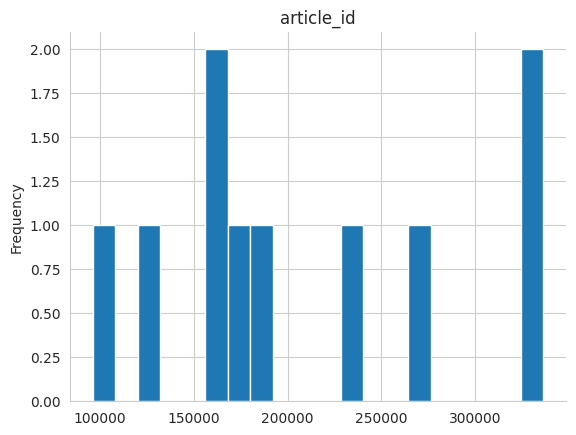

In [ ]:
from matplotlib import pyplot as plt
top_10_articles['article_id'].plot(kind='hist', bins=20, title='article_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

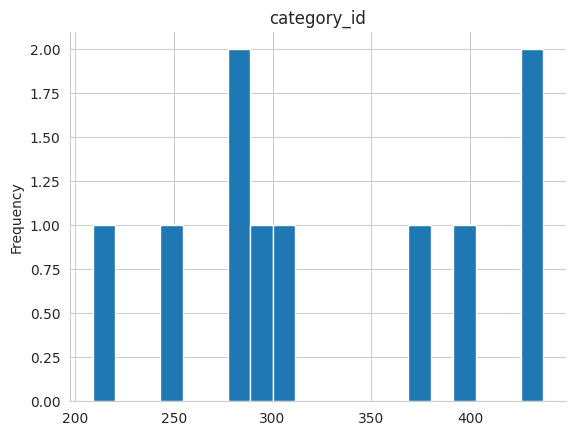

In [ ]:
from matplotlib import pyplot as plt
top_10_articles['category_id'].plot(kind='hist', bins=20, title='category_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

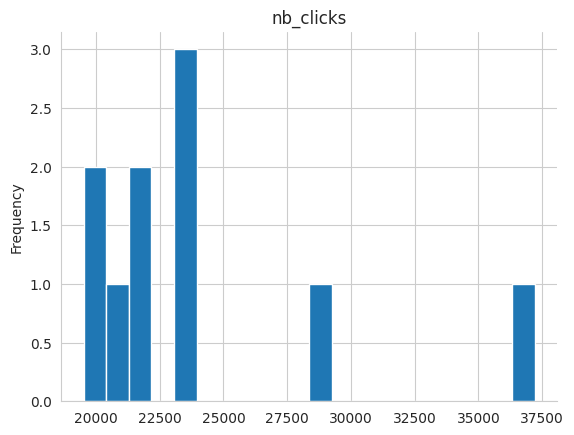

In [ ]:
from matplotlib import pyplot as plt
top_10_articles['nb_clicks'].plot(kind='hist', bins=20, title='nb_clicks')
plt.gca().spines[['top', 'right',]].set_visible(False)

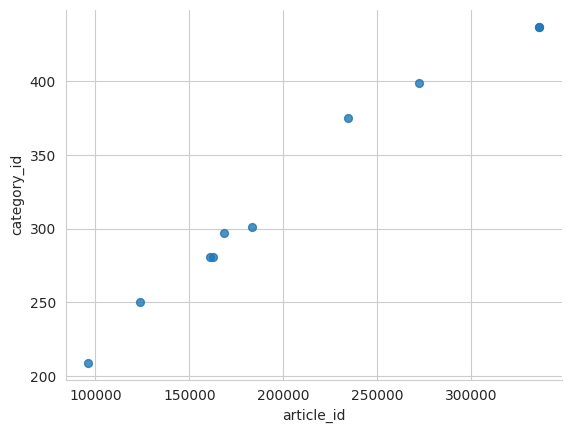

In [ ]:
from matplotlib import pyplot as plt
top_10_articles.plot(kind='scatter', x='article_id', y='category_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

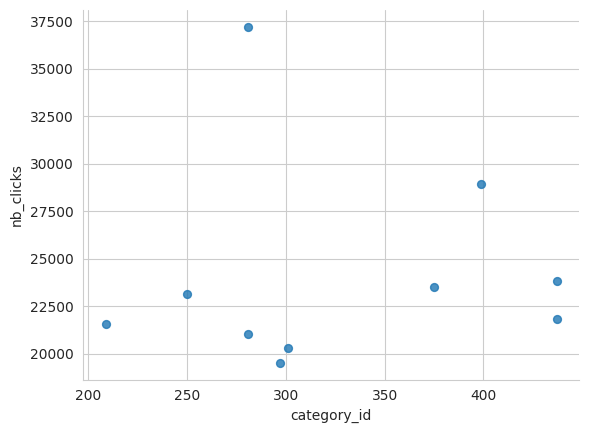

In [ ]:
from matplotlib import pyplot as plt
top_10_articles.plot(kind='scatter', x='category_id', y='nb_clicks', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

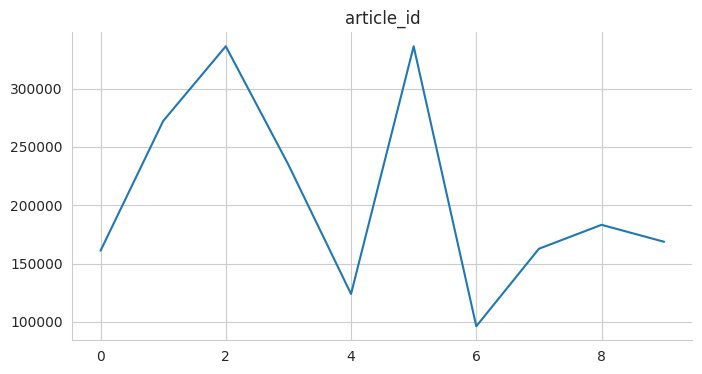

In [ ]:
from matplotlib import pyplot as plt
top_10_articles['article_id'].plot(kind='line', figsize=(8, 4), title='article_id')
plt.gca().spines[['top', 'right']].set_visible(False)

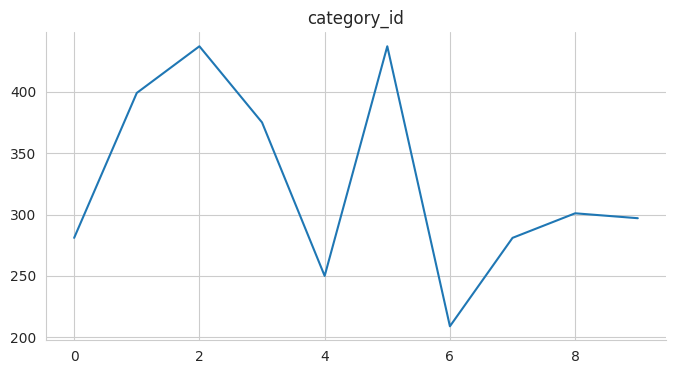

In [ ]:
from matplotlib import pyplot as plt
top_10_articles['category_id'].plot(kind='line', figsize=(8, 4), title='category_id')
plt.gca().spines[['top', 'right']].set_visible(False)

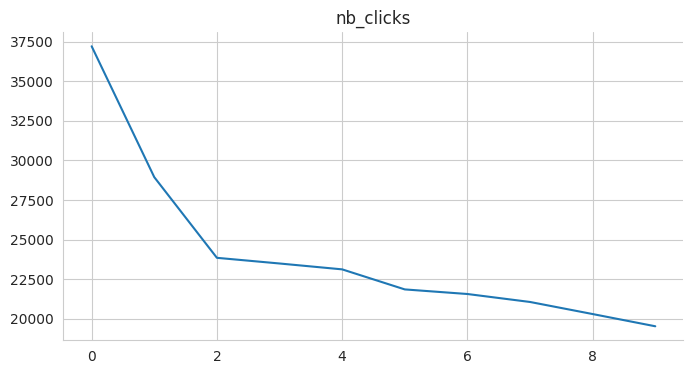

In [ ]:
from matplotlib import pyplot as plt
top_10_articles['nb_clicks'].plot(kind='line', figsize=(8, 4), title='nb_clicks')
plt.gca().spines[['top', 'right']].set_visible(False)

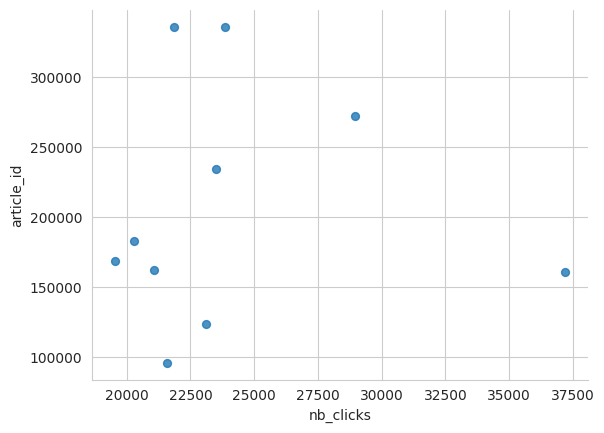

In [ ]:
from matplotlib import pyplot as plt
top_10_articles.plot(kind='scatter', x='nb_clicks', y='article_id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
display(article_clicks.describe()) # Affiche les statistiques (moyenne, médiane, etc.)

,0
count,43029.000000
mean,65.089242
std,635.521355
min,1.000000
25%,1.000000
50%,1.000000
75%,6.000000
max,37208.000000


In [ ]:
print("\nTop 10 des articles les plus populaires :")
top_10_articles = article_clicks.head(10).to_frame(name='nb_clicks').reset_index()
top_10_articles = top_10_articles.merge(items[['article_id', 'category_id']], left_on='click_article_id', right_on='article_id', how='left')
display(top_10_articles[['article_id', 'category_id', 'nb_clicks']])


Top 10 des articles les plus populaires :


,article_id,category_id,nb_clicks
0,160974,281,37208
1,272143,399,28942
2,336221,437,23849
3,234698,375,23491
4,123909,250,23120
5,336223,437,21854
6,96210,209,21564
7,162655,281,21061
8,183176,301,20298
9,168623,297,19526


**Interprétation :** Nous observons également une distribution en longue traîne pour les articles. Quelques articles sont extrêmement populaires, tandis que la grande majorité reçoit très peu de clics. Les modèles basés sur la popularité seront fortement influencés par ces quelques articles "superstars". Notre objectif sera aussi de recommander des articles pertinents de la "longue traîne".

#### Analyse des Catégories d'Articles

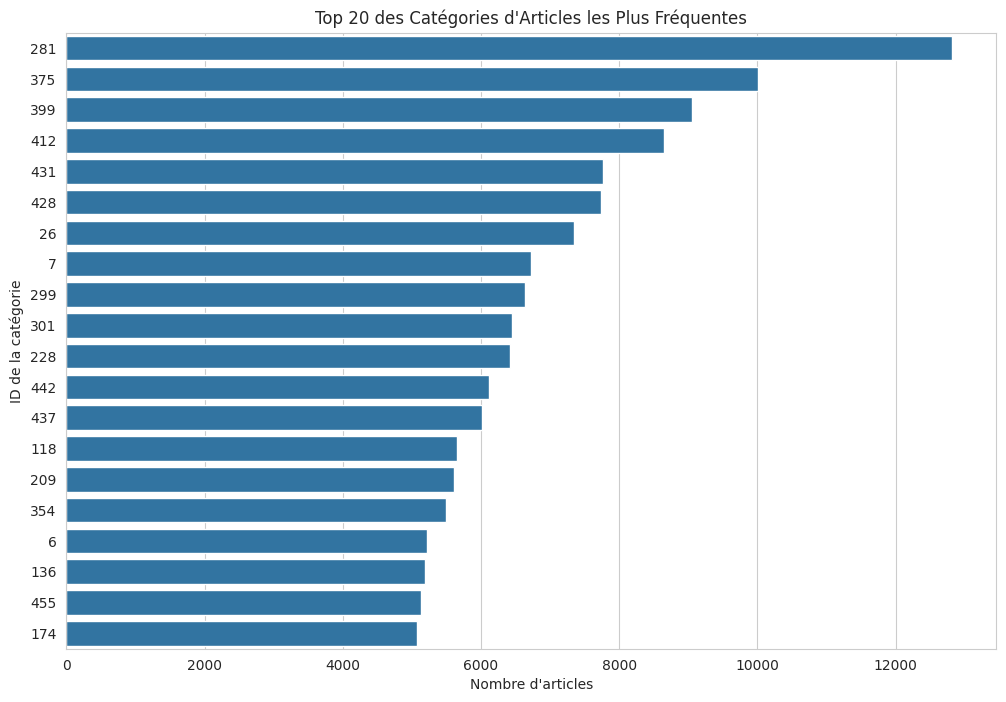

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(y='category_id', data=items, order = items['category_id'].value_counts().index[:20])
plt.title('Top 20 des Catégories d\'Articles les Plus Fréquentes')
plt.xlabel("Nombre d'articles")
plt.ylabel('ID de la catégorie')
plt.show()

## **3. Visualisation des Embeddings avec t-SNE**
Pour vérifier la qualité sémantique de nos embeddings d'articles (`items2vec`), nous utilisons **t-SNE (t-distributed Stochastic Neighbor Embedding)**. C'est une technique de réduction de dimensionnalité qui nous permet de visualiser nos données de haute dimension (250 dimensions pour chaque article) dans un espace 2D.

**Objectif :** Vérifier si les articles d'une même catégorie se regroupent naturellement. Si c'est le cas, cela signifie que nos embeddings capturent bien le sens et le contenu des articles, ce qui est une excellente nouvelle pour nos modèles Content-Based.

Exécution de t-SNE sur 1181 articles des 10 catégories les plus populaires...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1181 samples in 0.001s...
[t-SNE] Computed neighbors for 1181 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1181
[t-SNE] Computed conditional probabilities for sample 1181 / 1181
[t-SNE] Mean sigma: 2.203760


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.921394
[t-SNE] KL divergence after 1000 iterations: 0.812795


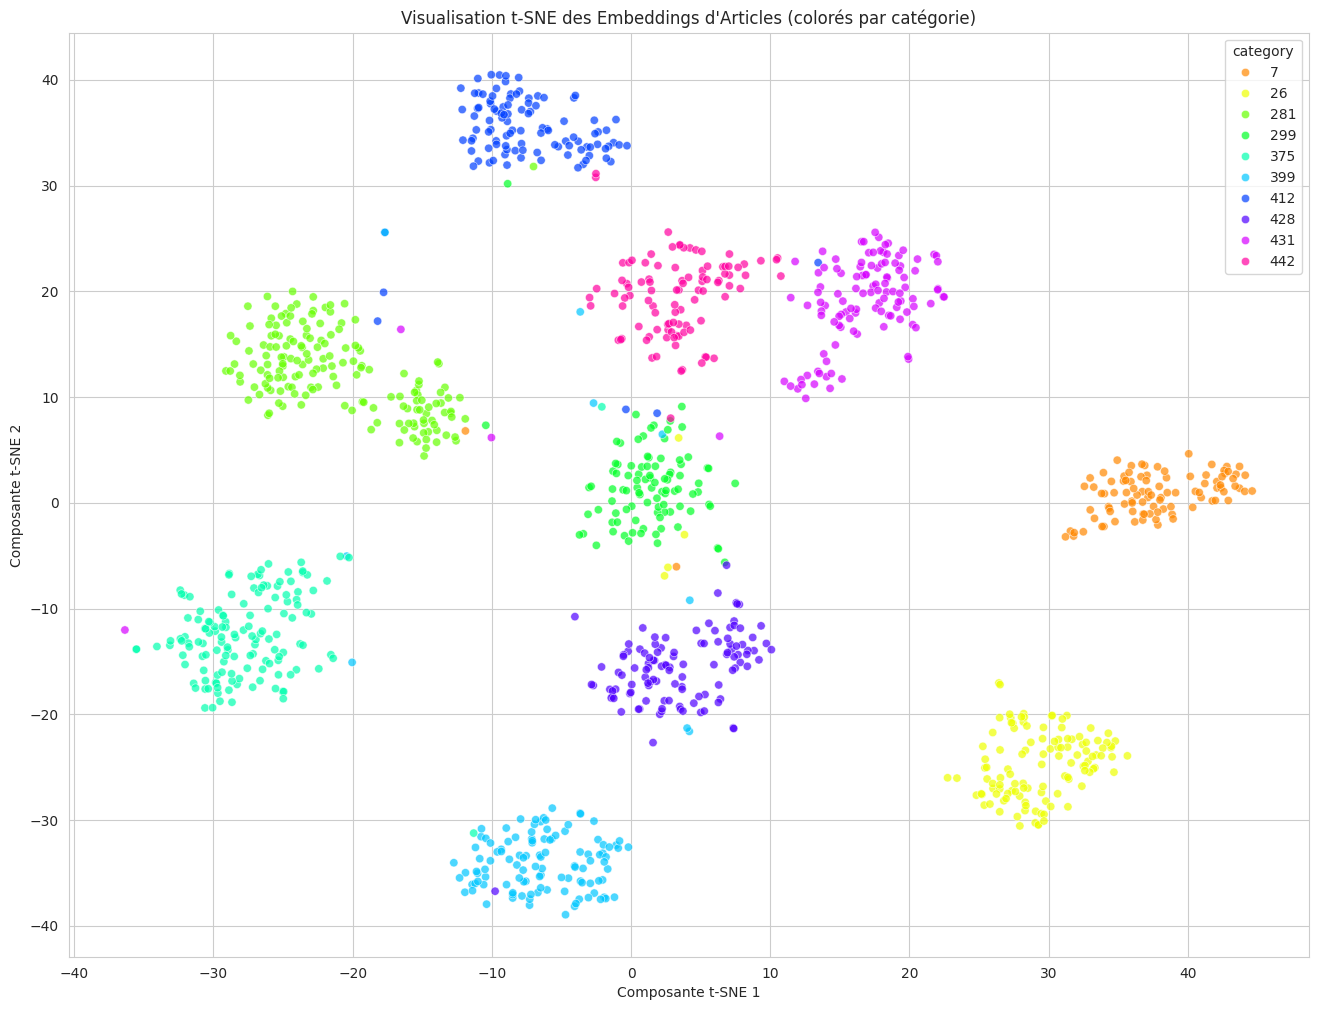

In [ ]:
# --- 1. Préparation des données pour t-SNE ---
# t-SNE est très coûteux en calcul, nous allons donc travailler sur un échantillon aléatoire pour obtenir un aperçu rapide.
n_articles_sample = 5000

sample_indices = np.random.choice(items.index, size=n_articles_sample, replace=False)

# Récupérer les métadonnées et les embeddings pour cet échantillon
sample_items_df = items.loc[sample_indices]
sample_embeddings = items2vec[sample_indices]
sample_categories = sample_items_df['category_id']

# Pour une meilleure lisibilité, nous nous concentrons sur les 10 catégories les plus populaires de l'échantillon.
top_categories = sample_categories.value_counts().nlargest(10).index
sample_items_filtered = sample_items_df[sample_items_df['category_id'].isin(top_categories)]
sample_embeddings_filtered = items2vec[sample_items_filtered.index]
labels = sample_items_filtered['category_id']

print(f"Exécution de t-SNE sur {len(sample_embeddings_filtered)} articles des 10 catégories les plus populaires...")

# --- 2. Exécution de l'algorithme t-SNE ---
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, verbose=1)
embeddings_2d = tsne.fit_transform(sample_embeddings_filtered)

# --- 3. Visualisation des résultats ---
tsne_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
tsne_df['category'] = labels.values

plt.figure(figsize=(16, 12))
sns.scatterplot(
    x='x', y='y',
    hue='category',
    palette=sns.color_palette("hsv", 10), # 10 couleurs pour nos 10 catégories
    data=tsne_df,
    legend="full",
    alpha=0.7
)
plt.title("Visualisation t-SNE des Embeddings d'Articles (colorés par catégorie)")
plt.xlabel('Composante t-SNE 1')
plt.ylabel('Composante t-SNE 2')
plt.show()

**Interprétation du graphique t-SNE :**
- **Clusters clairs :** Si vous observez des amas de points de la même couleur, c'est un excellent signe. Cela signifie que les articles de la même catégorie sont sémantiquement proches dans l'espace des embeddings.
- **Chevauchement :** Des clusters qui se chevauchent peuvent indiquer des catégories thématiquement proches (ex: 'politique' et 'économie').
- **Dispersion :** Si les points de toutes les couleurs sont mélangés de manière chaotique, cela pourrait signifier que les embeddings ne capturent pas bien l'information de catégorie, ou que les catégories elles-mêmes sont très larges et hétérogènes.

## **4. Préparation des données pour la modélisation**

### **Fonction de Découpe et de Préparation des Données**
Cette fonction `cut_data_by_qtime` est cruciale. Elle simule un point dans le temps en ne gardant que les interactions et les articles créés avant un certain quantile temporel. Cela permet de créer des ensembles d'entraînement et de test qui respectent la chronologie des événements, évitant ainsi la fuite de données du futur vers le passé.

In [ ]:
def cut_data_by_qtime(qtime=0.5):
    """
    Découpe les données en fonction d'un quantile de temps pour simuler un point de coupure.
    Cela garantit que l'on n'entraîne le modèle que sur les données disponibles jusqu'à un certain moment,
    et qu'on ne recommande pas d'articles qui n'existaient pas encore.
    """
    # 1. Déterminer le timestamp de coupure basé sur le quantile des clics
    cut_click = clics.click_timestamp.quantile(qtime)

    # 2. Préparer les données d'articles et de clics en ne gardant que ce qui est antérieur à la coupure
    items_ = pd.concat([items, pd.DataFrame(items2vec)], axis=1)
    clics__ = clics.loc[clics.click_timestamp < cut_click].copy()
    items__ = items_.loc[items_.created_at_ts < cut_click].copy()

    # 3. Filtrer les clics pour ne garder que ceux portant sur des articles qui existent dans notre jeu d'articles filtré
    data = clics__.loc[clics__.click_article_id.isin(set(items__.article_id))].copy()
    data.rename(columns={'click_article_id':'article_id'}, inplace = True)

    # 4. Agréger les interactions : Compter le nombre de clics par paire (utilisateur, article, timestamp)
    data_map = data.groupby(['user_id', 'article_id', 'click_timestamp']).size().to_frame('nb').reset_index()

    # 5. Préparer les objets finaux : embeddings, et dictionnaires de mapping
    items2vec_ = items__.iloc[:,5:].to_numpy()

    # Dictionnaires de mapping ID interne / ID brut
    dico_inner_raw_iid = dict( (inner_iid,iid) for inner_iid,iid in enumerate(items__.article_id ))
    dico_raw_inner_iid = dict( (iid,inner_iid) for inner_iid,iid in enumerate(items__.article_id ))

    print(f"Découpe réalisée (q={qtime}). Interactions restantes: {len(data)}. Articles restants: {len(items__)}")
    return data_map, items__, items2vec_, dico_inner_raw_iid, dico_raw_inner_iid

## **5. Définition des Classes de Modèles**

Nous définissons une structure de classes standard pour tous nos modèles. Chaque classe doit avoir :
- `get_model_name()`: Renvoie le nom du modèle.
- `fit()`: Entraîne le modèle sur les données d'entraînement.
- `recommend_items(uid, topn)`: Génère des recommandations pour un utilisateur donné.

  ### **Modèles Basés sur la Popularité**

In [ ]:
class PopularityFiltRecommender: # Modèle le plus simple
    MODEL_NAME = 'Popularity-Filtering'

    def __init__(self,data_map):
        self.train_user_interact = data_map
        self.raw_reco = None

    def get_model_name(self):
        return self.MODEL_NAME

    def fit(self):
        # Calcule la popularité de chaque article en sommant le nombre de clics ('nb').
        # Ici, 'nb' agit comme un "rating" : plus il est élevé, plus l'article est populaire.
        self.raw_reco=self.train_user_interact.groupby('article_id')['nb'].sum().sort_values(ascending=False).reset_index()

    def recommend_items(self,uid,topn=5):
        # Recommande simplement les N articles les plus populaires, quelle que soit l'utilisateur
        return self.raw_reco.head(topn) if topn > 0 else self.raw_reco

class RecentPopularityRecommender: # Modèle de popularité sensible au temps
    MODEL_NAME = 'Recent-Popularity'

    def __init__(self, data_map):
        self.train_user_interact = data_map
        self.raw_reco = None

    def get_model_name(self):
        return self.MODEL_NAME

    def fit(self):
        # Calcule la popularité uniquement sur les interactions les plus récentes (dernier quartile)
        recent_time_threshold = self.train_user_interact['click_timestamp'].quantile(0.75)
        recent_clicks = self.train_user_interact[self.train_user_interact['click_timestamp'] >= recent_time_threshold]
        # La popularité est calculée en sommant le "rating" implicite ('nb') des clics récents.
        self.raw_reco = recent_clicks.groupby('article_id')['nb'].sum().sort_values(ascending=False).reset_index()

    def recommend_items(self, uid, topn=5):
        # Recommande les articles qui sont devenus populaires récemment
        return self.raw_reco.head(topn) if topn > 0 else self.raw_reco

class PopularityByCategoryRecommender: # Modèle de popularité personnalisé par catégorie
    MODEL_NAME = 'Popularity-By-Category'

    def __init__(self, data_map, items_df):
        self.train_user_interact = data_map
        self.items_df = items_df
        self.category_popularity = None

    def get_model_name(self):
        return self.MODEL_NAME

    def fit(self):
        # Pré-calcule la popularité de chaque article au sein de sa catégorie
        merged_df = self.train_user_interact.merge(self.items_df[['article_id', 'category_id']], on='article_id')
        # La popularité par catégorie est aussi basée sur la somme des "ratings" ('nb').
        self.category_popularity = merged_df.groupby(['category_id', 'article_id'])['nb'].sum().reset_index()
        self.category_popularity = self.category_popularity.sort_values('nb', ascending=False)

    def recommend_items(self, uid, topn=5):
        # 1. Trouver les catégories préférées de l'utilisateur
        user_clicks = self.train_user_interact[self.train_user_interact['user_id'] == uid]
        user_items = user_clicks.merge(self.items_df[['article_id', 'category_id']], on='article_id')

        if user_items.empty:
            # Pour les nouveaux utilisateurs (cold start), on se rabat sur la popularité globale
            pop_reco = self.category_popularity.groupby('article_id')['nb'].sum().sort_values(ascending=False).reset_index()
            return pop_reco.head(topn)

        # 2. Identifier les 3 catégories les plus lues par l'utilisateur
        top_categories = user_items['category_id'].value_counts().index[:3] # Top 3 catégories

        # 3. Recommander les articles les plus populaires de ces catégories
        recs = self.category_popularity[self.category_popularity['category_id'].isin(top_categories)]

        # 4. Filtrer les articles déjà vus et retourner le top N
        items_to_ignore = set(user_clicks['article_id'])
        recs = recs[~recs['article_id'].isin(items_to_ignore)]

        recs = recs.drop_duplicates(subset='article_id').sort_values('nb', ascending=False)
        return recs.head(topn) if topn > 0 else recs

### **Modèles Basés sur le Contenu (Content-Based)**

In [ ]:
class ContentBasedRecommender: # Modèle basé sur le contenu, profil utilisateur complet
    MODEL_NAME = 'Content-Based'

    def __init__(self,data_map,i2vec,dic_ri,dic_ir):
        self.dic_ir = dic_ir
        self.dic_ri = dic_ri
        self.items_embedding = i2vec
        self.train_user_interact = data_map
        self.user_profiles = {}

    def _build_users_profile(self,uid, click_df,emb_matrix,dic_ri):
        """Construit le profil d'un utilisateur comme la moyenne pondérée des embeddings des articles qu'il a lus."""
        click_uid_df = click_df.loc[click_df.user_id==uid]
        # Récupère les embeddings des articles lus
        user_item_profiles = np.array([emb_matrix[dic_ri[iid]] for iid in click_uid_df['article_id'] if iid in dic_ri])
        if len(user_item_profiles) == 0:
            return np.zeros((1, self.items_embedding.shape[1]))

        # PRISE EN COMPTE DU RATING : Le nombre de clics ('nb') est utilisé comme un poids (rating).
        # Un article cliqué plusieurs fois aura plus d'influence sur le profil de l'utilisateur.
        user_item_strengths = np.array(click_uid_df['nb']).reshape(-1,1)
        # Calcule la moyenne des embeddings des articles, pondérée par ce "rating".
        sum_of_strengths = np.sum(user_item_strengths)
        if sum_of_strengths == 0:
            return np.zeros((1, self.items_embedding.shape[1]))

        user_item_strengths_weighted_avg = np.sum(user_item_profiles * user_item_strengths, axis=0) / sum_of_strengths
        # Normalise le profil pour que sa norme soit de 1 (important pour la similarité cosinus)
        return preprocessing.normalize(user_item_strengths_weighted_avg.reshape(1, -1))

    def get_model_name(self):
        return self.MODEL_NAME

    def fit(self):
        # Construit le profil pour chaque utilisateur unique dans les données d'entraînement
        for uid in tqdm(self.train_user_interact.user_id.unique(), desc="Building User Profiles"):
            self.user_profiles[uid] = self._build_users_profile(uid, self.train_user_interact, self.items_embedding, self.dic_ri)

    def recommend_items(self, uid, topn=10, items_to_filter=None):
        if uid not in self.user_profiles:
            return pd.DataFrame(columns=['article_id', 'cb_cosine_with_profile'])

        # 1. Calcule la similarité cosinus entre le profil de l'utilisateur et TOUS les articles
        cosine_similarities = cosine_similarity(self.user_profiles[uid], self.items_embedding)
        # 2. Trie les articles par similarité décroissante
        similar_indices = cosine_similarities.argsort().flatten()[::-1]
        similar_items = [(self.dic_ir[i], cosine_similarities[0,i]) for i in similar_indices if i in self.dic_ir]

        # 3. Filtre les articles que l'utilisateur a déjà lus
        items_to_ignore = set(self.train_user_interact.loc[self.train_user_interact.user_id==uid].article_id)
        reco = pd.DataFrame(similar_items, columns=['article_id', 'cb_cosine_with_profile'])
        reco = reco[~reco.article_id.isin(items_to_ignore)]

        # Filtre optionnel pour l'évaluation
        if items_to_filter is not None:
            reco = reco[reco['article_id'].isin(items_to_filter)]

        return reco.head(topn) if topn > 0 else reco

class ContentBasedLastClickRecommender(ContentBasedRecommender): # Basé sur l'intérêt à court terme
    MODEL_NAME = 'Content-Based-Last-Click'

    def fit(self):
        pass # Pas de fit global, le profil est calculé à la volée

    def recommend_items(self, uid, topn=10, items_to_filter=None):
        user_clicks = self.train_user_interact[self.train_user_interact.user_id == uid]
        if user_clicks.empty:
            return pd.DataFrame(columns=['article_id', 'cb_cosine_with_profile'])

        # 1. Trouve le dernier article sur lequel l'utilisateur a cliqué
        last_click = user_clicks.sort_values('click_timestamp', ascending=False).iloc[0]
        last_article_id = last_click['article_id']

        # 2. Utilise l'embedding de cet article comme un "profil utilisateur temporaire"
        last_article_inner_id = self.dic_ri.get(last_article_id)
        if last_article_inner_id is None:
            return pd.DataFrame(columns=['article_id', 'cb_cosine_with_profile'])

        user_profile = self.items_embedding[last_article_inner_id].reshape(1, -1)
        # 3. Recommande des articles similaires à ce dernier article
        cosine_similarities = cosine_similarity(user_profile, self.items_embedding)
        similar_indices = cosine_similarities.argsort().flatten()[::-1]
        similar_items = [(self.dic_ir[i], cosine_similarities[0,i]) for i in similar_indices if i in self.dic_ir]

        # 4. Filtre et retourne le top N
        items_to_ignore = set(user_clicks.article_id)
        reco_df = pd.DataFrame(similar_items, columns=['article_id', 'cb_cosine_with_profile'])
        reco = reco_df[~reco_df.article_id.isin(items_to_ignore)]

        # Filtre optionnel pour l'évaluation
        if items_to_filter is not None:
            reco = reco[reco['article_id'].isin(items_to_filter)]

        return reco.head(topn) if topn > 0 else reco

class ContentBasedMostInteractedItemRecommender(ContentBasedRecommender): # Basé sur l'article "préféré"
    MODEL_NAME = 'Content-Based-Most-Interacted'

    def fit(self):
        pass # Pas de fit global

    def recommend_items(self, uid, topn=10, items_to_filter=None):
        user_clicks = self.train_user_interact[self.train_user_interact.user_id == uid]
        if user_clicks.empty:
            return pd.DataFrame(columns=['article_id', 'cb_cosine_with_profile'])

        # 1. Trouve l'article avec lequel l'utilisateur a le plus interagi
        most_interacted = user_clicks.sort_values('nb', ascending=False).iloc[0]
        fav_article_id = most_interacted['article_id']

        # 2. Utilise l'embedding de cet article comme profil
        fav_article_inner_id = self.dic_ri.get(fav_article_id)
        if fav_article_inner_id is None:
            return pd.DataFrame(columns=['article_id', 'cb_cosine_with_profile'])

        user_profile = self.items_embedding[fav_article_inner_id].reshape(1, -1)
        # 3. Recommande des articles similaires à cet article "préféré"
        cosine_similarities = cosine_similarity(user_profile, self.items_embedding)
        similar_indices = cosine_similarities.argsort().flatten()[::-1]
        similar_items = [(self.dic_ir[i], cosine_similarities[0,i]) for i in similar_indices if i in self.dic_ir]

        # 4. Filtre et retourne le top N
        items_to_ignore = set(user_clicks.article_id)
        reco_df = pd.DataFrame(similar_items, columns=['article_id', 'cb_cosine_with_profile'])
        reco = reco_df[~reco_df.article_id.isin(items_to_ignore)]

        # Filtre optionnel pour l'évaluation
        if items_to_filter is not None:
            reco = reco[reco['article_id'].isin(items_to_filter)]

        return reco.head(topn) if topn > 0 else reco

class ContentBasedTimeDecayRecommender(ContentBasedRecommender):
    MODEL_NAME = 'Content-Based-Time-Decay'

    def __init__(self, data_map, i2vec, dic_ri, dic_ir, decay_rate=0.05):
        super().__init__(data_map, i2vec, dic_ri, dic_ir)
        self.decay_rate = decay_rate # Lambda (λ) pour la décroissance
        self.MODEL_NAME = f'Content-Based-Time-Decay(λ={decay_rate})'

    def _build_users_profile(self, uid, click_df, emb_matrix, dic_ri):
        """Surcharge la méthode pour inclure la décroissance temporelle."""
        click_uid_df = click_df.loc[click_df.user_id == uid]
        if click_uid_df.empty:
            return np.zeros((1, self.items_embedding.shape[1]))

        # Calcul de la décroissance temporelle
        latest_timestamp = click_uid_df['click_timestamp'].max()
        time_diff_days = (latest_timestamp - click_uid_df['click_timestamp']) / (3600 * 24)
        time_decay_weight = np.exp(-self.decay_rate * time_diff_days)

        # PRISE EN COMPTE DU RATING : Le poids final est une combinaison du "rating" ('nb') et de la décroissance temporelle.
        # Une interaction récente avec un "rating" élevé aura le plus de poids.
        final_weights = (click_uid_df['nb'] * time_decay_weight).values.reshape(-1, 1)

        user_item_profiles = np.array([emb_matrix[dic_ri[iid]] for iid in click_uid_df['article_id'] if iid in dic_ri])
        sum_of_weights = np.sum(final_weights)
        if sum_of_weights == 0:
            return np.zeros((1, self.items_embedding.shape[1]))

        weighted_avg_profile = np.sum(user_item_profiles * final_weights, axis=0) / sum_of_weights
        return preprocessing.normalize(weighted_avg_profile.reshape(1, -1))

### **Modèles de Filtrage Collaboratif (avec `surprise`)**
Ces modèles utilisent les interactions explicites (ici, le nombre de clics `nb` comme un "rating") pour trouver des similarités.

In [ ]:
class CollabFiltRecommender: # Modèle de base pour les algorithmes de Surprise
    MODEL_NAME = 'Collaborative-Filtering-SVDpp'

    def __init__(self,data_map):
        self.train_user_interact = data_map
        self.algo = None

    def get_model_name(self):
        return self.MODEL_NAME

    def fit(self):
        # 1. Prépare les données pour la bibliothèque Surprise
        reader = Reader(rating_scale=(0,5)) # L'échelle est indicative, les vraies valeurs peuvent dépasser 5.
        # PRISE EN COMPTE DU RATING : La colonne 'nb' est explicitement passée comme étant le "rating".
        # Surprise va interpréter un 'nb' élevé comme un signal d'intérêt fort.
        data = Dataset.load_from_df(self.train_user_interact[['user_id','article_id','nb']], reader)
        trainset = data.build_full_trainset()
        # 2. Entraîne l'algorithme SVD++, une version améliorée de SVD qui prend en compte les interactions implicites.
        self.algo = SVDpp(n_epochs=20, lr_all=0.007, reg_all=0.1, random_state=42)
        self.algo.fit(trainset)

    def recommend_items(self,uid,topn=5):
        # 1. Identifie les articles que l'utilisateur n'a pas encore vus
        iid_to_ignore=set(self.train_user_interact.loc[self.train_user_interact.user_id==uid].article_id)
        all_items = set(self.train_user_interact.article_id)
        items2pred_ids = all_items - iid_to_ignore

        # 2. Prédit un score pour chaque article non vu
        predictions = [self.algo.predict(uid=uid, iid=iid) for iid in items2pred_ids]

        # 3. Trie les prédictions et retourne le top N
        recs = [(pred.iid, pred.est) for pred in predictions]
        recommendations_df = pd.DataFrame(recs, columns=['article_id', 'pred']).sort_values(by='pred', ascending=False)

        return recommendations_df.head(topn) if topn > 0 else recommendations_df

class CollabFiltSVDRecommender(CollabFiltRecommender): # Factorisation de matrice classique
    MODEL_NAME = 'Collaborative-Filtering-SVD'
    def fit(self):
        reader = Reader(rating_scale=(0, 5))
        # PRISE EN COMPTE DU RATING : Comme pour SVDpp, 'nb' est utilisé comme le rating.
        data = Dataset.load_from_df(self.train_user_interact[['user_id', 'article_id', 'nb']], reader)
        trainset = data.build_full_trainset()
        # Utilise l'algorithme SVD, un standard de la factorisation de matrice.
        self.algo = SVD(n_epochs=20, lr_all=0.005, reg_all=0.1, random_state=42)
        self.algo.fit(trainset)

class CollabFiltKNNRecommender(CollabFiltRecommender): # Approche basée sur les voisins
    MODEL_NAME = 'Collaborative-Filtering-KNN'
    def fit(self):
        reader = Reader(rating_scale=(0, 5))
        # PRISE EN COMPTE DU RATING : 'nb' est également utilisé ici pour calculer les similarités entre articles.
        data = Dataset.load_from_df(self.train_user_interact[['user_id', 'article_id', 'nb']], reader)
        trainset = data.build_full_trainset()
        # Utilise une approche basée sur les voisins (item-based) : un article est recommandé s'il est similaire à d'autres articles que l'utilisateur a aimés.
        sim_options = {'name': 'cosine', 'user_based': False} # Item-based
        self.algo = KNNWithMeans(sim_options=sim_options)
        self.algo.fit(trainset)

### **Modèle Hybride**
L'objectif du modèle hybride est de combiner les forces de plusieurs approches pour pallier leurs faiblesses respectives. Ici, nous combinons :
- **Filtrage Collaboratif (CF) :** Très bon pour capturer les goûts subtils et la sérendipité à partir des interactions collectives (ici, SVDpp).
- **Filtrage Basé sur le Contenu (CB) :** Excellent pour gérer le problème du "cold start" (nouveaux articles) et pour recommander des articles de niche.

La combinaison se fait par une **somme pondérée des scores normalisés** des deux modèles.

In [ ]:
class HybridRecommender: # Combine les scores de plusieurs modèles
    MODEL_NAME = 'Hybrid-Filtering'

    def __init__(self, data_map, i2vec, dic_ri, dic_ir, items_df, cf_weight=0.5, cb_weight=0.5):
        self.train_user_interact = data_map
        self.dic_ir = dic_ir
        self.dic_ri = dic_ri
        self.items_embedding = i2vec
        self.items_df = items_df
        self.cf_weight = cf_weight
        self.cb_weight = cb_weight
        self.MODEL_NAME = f'Hybrid-W(cf={cf_weight:.2f},cb={cb_weight:.2f})'
        self.cf_model = None
        self.cb_model = None
        self.pf_model = None

    def get_model_name(self):
        return self.MODEL_NAME

    def fit(self, cf_model=None, cb_model=None, pf_model=None):
        # Entraîne chaque sous-modèle. On peut aussi passer des modèles pré-entraînés pour l'optimisation.
        self.cf_model = cf_model or CollabFiltRecommender(self.train_user_interact) # Utilise SVDpp par défaut
        self.cf_model.fit()

        self.cb_model = cb_model or ContentBasedTimeDecayRecommender(self.train_user_interact, self.items_embedding, self.dic_ri, self.dic_ir)
        self.cb_model.fit()

        self.pf_model = pf_model or PopularityFiltRecommender(self.train_user_interact)
        self.pf_model.fit()

    def recommend_items(self, uid, topn=10):
        # Handle cold start users (users not in the training data)
        if uid not in self.train_user_interact['user_id'].unique():
            # Return an empty DataFrame with the expected columns for consistency
            return pd.DataFrame(columns=['article_id', 'norm_score_cf', 'norm_score_cb', 'final_score'])


        items_to_ignore = set(self.train_user_interact.loc[self.train_user_interact.user_id == uid, 'article_id'])

        # 1. Obtenir les recommandations complètes de chaque sous-modèle
        reco_cf = self.cf_model.recommend_items(uid, topn=0)
        reco_cb = self.cb_model.recommend_items(uid, topn=0)

        # 2. Normaliser les scores de chaque modèle (entre 0 et 1) pour les rendre comparables
        # La normalisation Min-Max est une technique courante pour cela.
        if not reco_cf.empty:
            reco_cf['norm_score'] = (reco_cf['pred'] - reco_cf['pred'].min()) / (reco_cf['pred'].max() - reco_cf['pred'].min() + 1e-5)
        else:
             reco_cf = pd.DataFrame(columns=['article_id', 'norm_score']) # Ensure columns exist even if empty

        if not reco_cb.empty:
            reco_cb['norm_score'] = (reco_cb['cb_cosine_with_profile'] - reco_cb['cb_cosine_with_profile'].min()) / (reco_cb['cb_cosine_with_profile'].max() - reco_cb['cb_cosine_with_profile'].min() + 1e-5)
        else:
            reco_cb = pd.DataFrame(columns=['article_id', 'norm_score']) # Ensure columns exist even if empty


        # 3. Fusionner les recommandations sur l'ID de l'article
        reco = pd.merge(reco_cf[['article_id', 'norm_score']], reco_cb[['article_id', 'norm_score']], on='article_id', how='outer', suffixes=('_cf', '_cb'))
        reco.fillna(0, inplace=True)

        # 4. Calculer le score final comme une somme pondérée
        reco['final_score'] = (self.cf_weight * reco['norm_score_cf']) + (self.cb_weight * reco['norm_score_cb'])
        # 5. Trier par score final et filtrer les articles déjà vus
        reco = reco.sort_values('final_score', ascending=False)

        reco = reco[~reco['article_id'].isin(items_to_ignore)]

        return reco.head(topn) if topn > 0 else reco

## **6. Définition du Cadre d'Évaluation (`ModelEvaluator`)**

Cette classe est le cœur de notre processus d'expérimentation. Elle permet d'évaluer n'importe quel modèle de manière standardisée en utilisant des métriques offline.

**Métriques utilisées :**
- **Recall@k** : Pourcentage d'articles pertinents du jeu de test qui apparaissent dans les k premières recommandations.
- **Mean Reciprocal Rank (MRR)** : Moyenne de l'inverse du rang de la première recommandation pertinente. Récompense les modèles qui classent les bons articles très haut.
- **Intra-List Similarity (ILS)** : Mesure à quel point les articles d'une même liste de recommandations sont similaires entre eux. Un score bas indique une meilleure diversité.

In [ ]:
class ModelEvaluator:
    def __init__(self, data_map, data_map_train, data_map_test, items_df, i2vec, dic_ri):
        self.full_user_interact = data_map
        self.train_user_interact = data_map_train
        self.test_user_interact = data_map_test
        self.full_items = items_df
        self.i2vec = i2vec # Nécessaire pour la métrique de diversité
        self.dic_ri = dic_ri # Nécessaire pour la métrique de diversité

    def get_random_sample(self, uid, sample_size=100, seed=42):
        # Récupère tous les articles sur lesquels l'utilisateur a interagi dans l'ensemble de données complet
        user_interacted_items = set(self.full_user_interact.loc[self.full_user_interact["user_id"]==uid]['article_id'])
        # Les candidats pour l'échantillonnage négatif sont tous les articles du catalogue filtré moins ceux déjà vus
        all_possible_items = set(self.full_items['article_id'])
        non_clicked_items = all_possible_items - user_interacted_items

        random.seed(seed)
        # S'assure de ne pas essayer de sampler plus d'éléments qu'il n'en existe
        sample_size = min(len(non_clicked_items), sample_size)
        non_clicked_items_sample = set(random.sample(list(non_clicked_items), min(len(non_clicked_items), sample_size)))
        return non_clicked_items_sample

    def _verify_hit_top_n(self, iid, recommended_items, topn):
        """Vérifie si un item est dans le top-N d'une liste de recommandations."""
        if isinstance(recommended_items, pd.Series):
            recommended_items = recommended_items.values

        try:
            index = next(i for i, c in enumerate(recommended_items) if c == iid)
        except StopIteration:
            index = -1
        hit = int(index != -1 and index < topn)
        return hit, index

    def _calculate_intra_list_similarity(self, recommended_items_ids):
        """Calcule la diversité d'une liste de recommandations (Intra-List Similarity)."""
        if len(recommended_items_ids) < 2:
            return 0.0

        reco_indices = [self.dic_ri[iid] for iid in recommended_items_ids if iid in self.dic_ri]
        if len(reco_indices) < 2:
            return 0.0

        reco_embeddings = self.i2vec[reco_indices]
        similarity_matrix = cosine_similarity(reco_embeddings)
        upper_triangle_indices = np.triu_indices_from(similarity_matrix, k=1)
        return np.mean(similarity_matrix[upper_triangle_indices])

    def evaluate_model_for_user(self, model, uid):
        """Évalue les recommandations pour un seul utilisateur."""
        all_available_item_ids = set(self.full_items['article_id'])
        uid_test_clicked_items = set(self.test_user_interact.article_id.loc[
            (self.test_user_interact['user_id'] == uid) &
            (self.test_user_interact['article_id'].isin(all_available_item_ids))
        ])
        uid_test_nb_clicked_items = len(uid_test_clicked_items)

        if uid_test_nb_clicked_items == 0:
            return {'hits@5_count':0, 'hits@10_count':0, 'interacted_count': 0, 'recall@5': 0, 'recall@10': 0, 'reciprocal_rank': 0, 'intra_list_similarity': 0}

        hits_at_5_count = 0
        hits_at_10_count = 0
        sum_reciprocal_rank = 0

        for iid in uid_test_clicked_items:
            uid_non_clicked_items_sample = self.get_random_sample(uid, sample_size=100, seed=int(iid)%(2**32))
            items_to_rank = list(uid_non_clicked_items_sample.union({iid}))

            uid_reco = model.recommend_items(uid, topn=0)
            filt_uid_reco = uid_reco[uid_reco['article_id'].isin(items_to_rank)]

            hit_at_5, rank = self._verify_hit_top_n(iid, filt_uid_reco['article_id'], 5)
            hits_at_5_count += hit_at_5
            hit_at_10, rank = self._verify_hit_top_n(iid, filt_uid_reco['article_id'], 10)
            hits_at_10_count += hit_at_10
            if rank != -1:
                sum_reciprocal_rank += 1 / (rank + 1)

        general_recos = model.recommend_items(uid, topn=10)
        top_10_reco_ids = general_recos['article_id'].tolist()
        intra_list_similarity = self._calculate_intra_list_similarity(top_10_reco_ids)

        recall_at_5 = hits_at_5_count / float(uid_test_nb_clicked_items)
        recall_at_10 = hits_at_10_count / float(uid_test_nb_clicked_items)
        avg_reciprocal_rank = sum_reciprocal_rank / uid_test_nb_clicked_items
        return {'hits@5_count':hits_at_5_count, 'hits@10_count':hits_at_10_count, 'interacted_count': uid_test_nb_clicked_items, 'recall@5': recall_at_5, 'recall@10': recall_at_10, 'reciprocal_rank': avg_reciprocal_rank, 'intra_list_similarity': intra_list_similarity}

    def evaluate_model(self, model,breaknb):
        """Évalue un modèle sur un échantillon d'utilisateurs du jeu de test."""
        people_metrics = []

        # On ne peut évaluer que les utilisateurs présents dans le jeu de test.
        test_user_ids = set(self.test_user_interact.user_id.unique())

        # Pour les modèles 'implicit', on ne peut évaluer que les utilisateurs qu'ils ont vus pendant l'entraînement.
        if hasattr(model, 'user_inv_map'):
            test_user_ids = test_user_ids.intersection(set(model.user_inv_map.keys()))
        list_uid = list(test_user_ids)
        random.shuffle(list_uid)

        # Boucle sur un échantillon d'utilisateurs pour accélérer l'évaluation
        for idx, uid in enumerate(tqdm(list_uid, desc=f"Evaluating {model.get_model_name()}")):
            if idx >= breaknb:
                break
            person_metrics = self.evaluate_model_for_user(model, uid)
            person_metrics['uid'] = uid
            people_metrics.append(person_metrics)

        results = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)

        # Agrégation des métriques au niveau global
        global_recall_at_5 = results['hits@5_count'].sum() / float(results['interacted_count'].sum())
        global_recall_at_10 = results['hits@10_count'].sum() / float(results['interacted_count'].sum())
        global_mrr = results['reciprocal_rank'].mean()
        global_ils = results['intra_list_similarity'].mean()

        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10,
                          'mrr': global_mrr,
                          'diversity_ils': global_ils}
        return global_metrics, results

## **7. Entraînement et Évaluation des Modèles**
C'est ici que nous mettons tout en œuvre. Nous allons instancier, entraîner et évaluer chaque modèle que nous avons défini.

### **Configuration de MLflow**
Nous configurons MLflow pour qu'il enregistre nos expériences dans un dossier spécifique sur Google Drive. Cela nous permettra de suivre et de comparer facilement les performances de nos modèles.

In [ ]:
# Indique à MLflow où sauvegarder les données. Le dossier 'mlruns' sera créé automatiquement.
mlflow.set_tracking_uri("file:///content/drive/MyDrive/P9_recommandation-contenu/mlruns")
mlflow.set_experiment("Recommandation_de_Contenu_P9")

/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 376, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 474, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/mlflow/store/tracking/file_store.py", line 1644, in _read_yaml
    return _read_helper(r

<Experiment: artifact_location='file:///content/drive/MyDrive/P9_recommandation-contenu/mlruns/113242309491874421', creation_time=1762583742645, experiment_id='113242309491874421', last_update_time=1762583742645, lifecycle_stage='active', name='Recommandation_de_Contenu_P9', tags={}>

### **Préparation des données Train/Test**
Nous utilisons notre fonction `cut_data_by_qtime` pour obtenir un snapshot des données, puis nous les divisons en ensembles d'entraînement (80%) et de test (20%).

In [ ]:
data_map, items_df, i2vec, dic_ir, dic_ri = cut_data_by_qtime(qtime=0.3)

data_map_sh = shuffle(data_map, random_state=42)
train, test = train_test_split(data_map_sh, test_size=0.20, random_state=42)

# Regrouper les interactions pour le train set (nécessaire pour certains modèles)
train = train.groupby(['user_id', 'article_id', 'click_timestamp'])['nb'].sum().reset_index()

print(f"Taille du jeu d'entraînement : {len(train)} interactions")
print(f"Taille du jeu de test : {len(test)} interactions")

Découpe réalisée (q=0.3). Interactions restantes: 840138. Articles restants: 247859
Taille du jeu d'entraînement : 672110 interactions
Taille du jeu de test : 168028 interactions


### **Évaluation des modèles**
Nous allons maintenant entraîner et évaluer chaque modèle défini précédemment sur un échantillon de 200 utilisateurs pour des raisons de rapidité.

In [ ]:
all_metrics = []
evaluation_break_nb = 200 # Limiter l'évaluation à 200 utilisateurs pour la rapidité

# Liste de tous les modèles à évaluer (focus sur CF et CB)
models_to_evaluate = [
    # --- Modèles Content-Based ---
    ContentBasedRecommender(train, i2vec, dic_ri, dic_ir),
    ContentBasedLastClickRecommender(train, i2vec, dic_ri, dic_ir),
    ContentBasedMostInteractedItemRecommender(train, i2vec, dic_ri, dic_ir),
    # --- Modèles Collaboratifs (Surprise) ---
    CollabFiltRecommender(train), # SVDpp
    CollabFiltSVDRecommender(train),
    CollabFiltKNNRecommender(train),
]

# Instanciation de l'évaluateur
model_evaluator = ModelEvaluator(data_map_sh, train, test, items_df, i2vec, dic_ri)

# Boucle d'évaluation
for model in models_to_evaluate:
    with mlflow.start_run(run_name=f"Baseline - {model.get_model_name()}", nested=True):
        print(f"--- Entraînement et évaluation du modèle : {model.get_model_name()} ---")
        mlflow.log_param("model_name", model.get_model_name())

        model.fit()
        metrics, _ = model_evaluator.evaluate_model(model=model, breaknb=evaluation_break_nb)
        all_metrics.append(metrics)
        print(metrics)

        # Correct metric names before logging to MLflow
        mlflow_metrics = {k.replace('@', '_'): v for k, v in metrics.items() if k != 'modelName'}
        mlflow.log_metrics(mlflow_metrics)

--- Entraînement et évaluation du modèle : Content-Based ---


Evaluating Content-Based:   0%|          | 200/93873 [11:00<85:59:29,  3.30s/it]


{'modelName': 'Content-Based', 'recall@5': 0.2733485193621868, 'recall@10': 0.37813211845102507, 'mrr': 0.25043742571794786, 'diversity_ils': 0.7541766092181206}
--- Entraînement et évaluation du modèle : Content-Based-Last-Click ---


Evaluating Content-Based-Last-Click:   0%|          | 200/93873 [05:57<46:28:58,  1.79s/it]


{'modelName': 'Content-Based-Last-Click', 'recall@5': 0.2123076923076923, 'recall@10': 0.28307692307692306, 'mrr': 0.20782726054476203, 'diversity_ils': 0.7813113304972649}
--- Entraînement et évaluation du modèle : Content-Based-Most-Interacted ---


Evaluating Content-Based-Most-Interacted:   0%|          | 200/93873 [06:31<50:55:25,  1.96s/it]


{'modelName': 'Content-Based-Most-Interacted', 'recall@5': 0.27466666666666667, 'recall@10': 0.33866666666666667, 'mrr': 0.2601678991629114, 'diversity_ils': 0.779392859339714}
--- Entraînement et évaluation du modèle : Collaborative-Filtering-SVDpp ---


Evaluating Collaborative-Filtering-SVDpp:   0%|          | 200/93873 [03:51<30:04:41,  1.16s/it]


{'modelName': 'Collaborative-Filtering-SVDpp', 'recall@5': 0.8161559888579387, 'recall@10': 0.9554317548746518, 'mrr': 0.3081271786492375, 'diversity_ils': 0.20052275}
--- Entraînement et évaluation du modèle : Collaborative-Filtering-SVD ---


Evaluating Collaborative-Filtering-SVD:   0%|          | 200/93873 [02:38<20:33:53,  1.27it/s]


{'modelName': 'Collaborative-Filtering-SVD', 'recall@5': 0.7893333333333333, 'recall@10': 0.9226666666666666, 'mrr': 0.33425826580632256, 'diversity_ils': 0.1958123}
--- Entraînement et évaluation du modèle : Collaborative-Filtering-KNN ---
Computing the cosine similarity matrix...
Done computing similarity matrix.


Evaluating Collaborative-Filtering-KNN:   0%|          | 200/93873 [02:58<23:13:31,  1.12it/s]

{'modelName': 'Collaborative-Filtering-KNN', 'recall@5': 0.7162162162162162, 'recall@10': 0.9513513513513514, 'mrr': 0.3511776781419638, 'diversity_ils': 0.26669177}


### **Tableau Récapitulatif des Performances**
Comparons les performances de tous les modèles sur nos métriques clés.

In [ ]:
comparison_df = pd.DataFrame(all_metrics).set_index('modelName')
print("\n--- Tableau Comparatif des Performances des Modèles ---")
display(comparison_df.sort_values('mrr', ascending=False))


--- Tableau Comparatif des Performances des Modèles ---


,recall@5,recall@10,mrr,diversity_ils
modelName,,,,
Collaborative-Filtering-KNN,0.716216,0.951351,0.351178,0.266692
Collaborative-Filtering-SVD,0.789333,0.922667,0.334258,0.195812
Collaborative-Filtering-SVDpp,0.816156,0.955432,0.308127,0.200523
Content-Based-Most-Interacted,0.274667,0.338667,0.260168,0.779393
Content-Based,0.273349,0.378132,0.250437,0.754177
Content-Based-Last-Click,0.212308,0.283077,0.207827,0.781311


## **8. Optimisation des Hyperparamètres et du Modèle Hybride**

### **8.1 Optimisation de l'Hyperparamètre `decay_rate` pour le modèle Content-Based**
L'hyperparamètre `decay_rate` (λ) contrôle la vitesse à laquelle l'importance des anciennes interactions diminue. Nous effectuons une recherche par grille pour trouver la meilleure valeur.

In [ ]:
# --- Grille de recherche pour le decay_rate ---
decay_rate_results = []
decay_rates_to_test = [0.01, 0.05, 0.1, 0.2, 0.5] # Valeurs candidates pour lambda

model_evaluator_decay = ModelEvaluator(data_map_sh, train, test, items_df, i2vec, dic_ri)

with mlflow.start_run(run_name="Optimisation Decay Rate (λ)"):
    mlflow.log_param("decay_rates_tested", decay_rates_to_test)
    for rate in decay_rates_to_test:
        print(f"\n--- Évaluation pour decay_rate = {rate} ---")

        # Évaluer ContentBasedTimeDecayRecommender
        with mlflow.start_run(run_name=f"CB Time Decay λ={rate}", nested=True):
            cb_td_model = ContentBasedTimeDecayRecommender(train, i2vec, dic_ri, dic_ir, decay_rate=rate)
            cb_td_model.fit()
            metrics_cb, _ = model_evaluator_decay.evaluate_model(model=cb_td_model, breaknb=evaluation_break_nb)
            decay_rate_results.append(metrics_cb)
            print(metrics_cb)
            mlflow.log_params({"model_type": "ContentBased", "decay_rate": rate})
            # Correct metric names before logging to MLflow
            mlflow_metrics_cb = {k.replace('@', '_'): v for k, v in metrics_cb.items() if k != 'modelName'}
            mlflow.log_metrics(mlflow_metrics_cb)

# --- Affichage et analyse des résultats ---
decay_results_df = pd.DataFrame(decay_rate_results)
print("\n--- Résultats de l'optimisation du decay_rate ---")
display(decay_results_df)


--- Évaluation pour decay_rate = 0.01 ---


Evaluating Content-Based-Time-Decay(λ=0.01):   0%|          | 200/93873 [10:12<79:38:06,  3.06s/it]


{'modelName': 'Content-Based-Time-Decay(λ=0.01)', 'recall@5': 0.2446236559139785, 'recall@10': 0.3279569892473118, 'mrr': 0.20163110260072337, 'diversity_ils': 0.7564562213420868}

--- Évaluation pour decay_rate = 0.05 ---


Evaluating Content-Based-Time-Decay(λ=0.05):   0%|          | 200/93873 [10:09<79:16:21,  3.05s/it]


{'modelName': 'Content-Based-Time-Decay(λ=0.05)', 'recall@5': 0.2776203966005666, 'recall@10': 0.3937677053824363, 'mrr': 0.2414081017899649, 'diversity_ils': 0.7788221371173859}

--- Évaluation pour decay_rate = 0.1 ---


Evaluating Content-Based-Time-Decay(λ=0.1):   0%|          | 200/93873 [09:35<74:53:16,  2.88s/it]


{'modelName': 'Content-Based-Time-Decay(λ=0.1)', 'recall@5': 0.23174603174603176, 'recall@10': 0.32063492063492066, 'mrr': 0.21542769522125296, 'diversity_ils': 0.7877046978473663}

--- Évaluation pour decay_rate = 0.2 ---


Evaluating Content-Based-Time-Decay(λ=0.2):   0%|          | 179/93873 [09:08<74:43:05,  2.87s/it]

In [ ]:
# --- Préparation des données pour la visualisation ---
decay_results_df['decay_rate'] = decay_results_df['modelName'].apply(lambda x: float(x.split('λ=')[1].replace(')', '')))

# Visualisation
fig, ax = plt.subplots(figsize=(14, 8))
sns.lineplot(data=decay_results_df, x='decay_rate', y='mrr', markers=True, lw=2)
plt.title('Performance (MRR) en fonction du decay_rate pour le modèle Content-Based Temporel')
plt.xlabel('Taux de Décroissance (λ)')
plt.ylabel('Mean Reciprocal Rank (MRR)')
plt.xscale('log')
plt.xticks(decay_rates_to_test, labels=decay_rates_to_test)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Identification du meilleur decay_rate ---
best_cb_decay_run = decay_results_df.loc[decay_results_df['mrr'].idxmax()]
best_cb_decay_rate = best_cb_decay_run['decay_rate']
print(f"\nMeilleur decay_rate pour Content-Based Time Decay: {best_cb_decay_rate} (MRR: {best_cb_decay_run['mrr']:.4f})")

### **8.2 Optimisation des Poids du Modèle Hybride**
Le modèle hybride combine les forces du filtrage collaboratif (SVDpp) et du filtrage basé sur le contenu. Nous effectuons une recherche par grille pour trouver la pondération optimale entre ces deux approches.

In [ ]:
# Pré-entraînement des sous-modèles pour ne pas avoir à les ré-entraîner à chaque itération
print("Pré-entraînement des sous-modèles pour l'optimisation...")
cf_model_prefit = CollabFiltRecommender(train) # SVDpp
cf_model_prefit.fit()

cb_model_prefit = ContentBasedTimeDecayRecommender(train, i2vec, dic_ri, dic_ir, decay_rate=best_cb_decay_rate)
cb_model_prefit.fit()

pf_model_prefit = PopularityFiltRecommender(train)
pf_model_prefit.fit()
print("Pré-entraînement terminé.")

# Grille de recherche pour les poids
hybrid_results = []
model_evaluator_opt = ModelEvaluator(data_map_sh, train, test, items_df, i2vec, dic_ri)

with mlflow.start_run(run_name="Optimisation_Poids_Modèle_Hybride"):
    mlflow.log_param("best_cb_decay_rate", best_cb_decay_rate)
    for w_cf in np.arange(0.0, 1.01, 0.1):
        w_cb = 1.0 - w_cf
        with mlflow.start_run(run_name=f"Hybrid Weights cf={w_cf:.1f},cb={w_cb:.1f}", nested=True):
            hr_model_opt = HybridRecommender(train, i2vec, dic_ri, dic_ir, items_df,
                                             cf_weight=w_cf, cb_weight=w_cb)

            hr_model_opt.cf_model = cf_model_prefit
            hr_model_opt.cb_model = cb_model_prefit
            hr_model_opt.pf_model = pf_model_prefit

            metrics, _ = model_evaluator_opt.evaluate_model(model=hr_model_opt, breaknb=evaluation_break_nb)
            hybrid_results.append(metrics)
            mlflow.log_params({"cf_weight": w_cf, "cb_weight": w_cb})
            # Correct metric names before logging to MLflow
            mlflow_metrics = {k.replace('@', '_'): v for k, v in metrics.items() if k != 'modelName'}
            mlflow.log_metrics(mlflow_metrics)

# Affichage des résultats de l'optimisation
hybrid_results_df = pd.DataFrame(hybrid_results)
all_metrics.extend(hybrid_results)
print("\n--- Résultats de l'optimisation des poids ---")
display(hybrid_results_df)

Pré-entraînement des sous-modèles pour l'optimisation...


Building User Profiles: 100%|██████████| 165342/165342 [04:37<00:00, 596.07it/s]


Pré-entraînement terminé.


Evaluating Hybrid-W(cf=1.00,cb=0.00):   0%|          | 200/93873 [13:53<108:26:06,  4.17s/it]


--- Résultats de l'optimisation des poids ---


,modelName,recall@5,recall@10,mrr,diversity_ils
0,"Hybrid-W(cf=0.00,cb=1.00)",0.241573,0.359551,0.230484,0.778068
1,"Hybrid-W(cf=0.10,cb=0.90)",0.335227,0.440341,0.300458,0.733959
2,"Hybrid-W(cf=0.20,cb=0.80)",0.372032,0.490765,0.318366,0.688298
3,"Hybrid-W(cf=0.30,cb=0.70)",0.641243,0.774011,0.503288,0.687835
4,"Hybrid-W(cf=0.40,cb=0.60)",0.682720,0.824363,0.509015,0.601260
5,"Hybrid-W(cf=0.50,cb=0.50)",0.797619,0.937500,0.528264,0.561130
6,"Hybrid-W(cf=0.60,cb=0.40)",0.867008,0.956522,0.501927,0.468293
7,"Hybrid-W(cf=0.70,cb=0.30)",0.852601,0.947977,0.468734,0.352683
8,"Hybrid-W(cf=0.80,cb=0.20)",0.807580,0.932945,0.368112,0.267019
9,"Hybrid-W(cf=0.90,cb=0.10)",0.848739,0.963585,0.367039,0.215936


### **Visualisation des résultats de l'optimisation**
Ce graphique nous aide à visualiser le compromis et à choisir la meilleure pondération. On cherche souvent le point où le MRR et le Recall@5 sont tous les deux élevés.

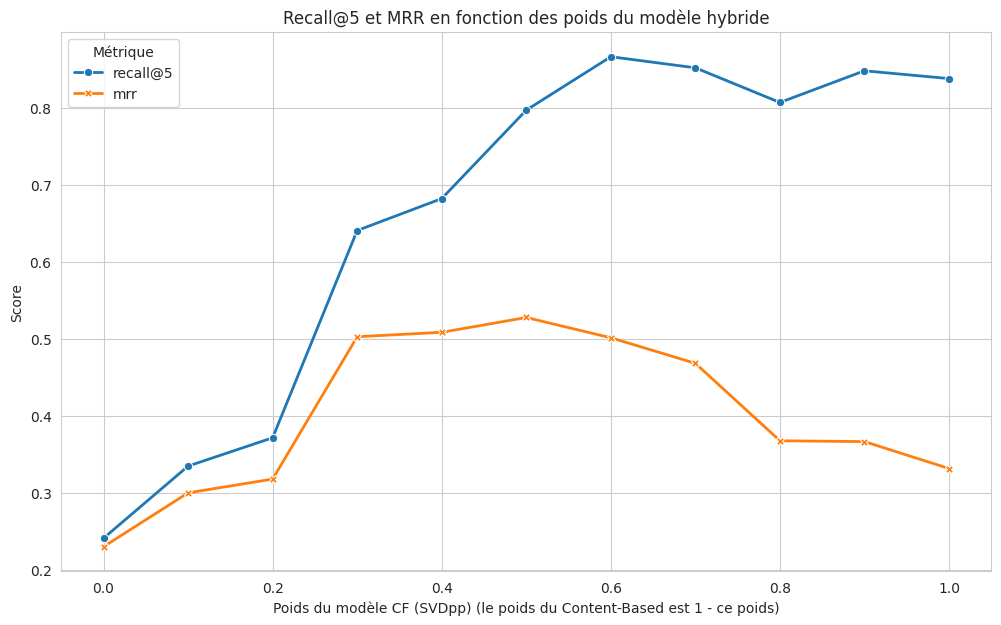

In [ ]:
# Préparation des données pour la visualisation
plot_df = hybrid_results_df.copy()
plot_df['cf_weight'] = plot_df['modelName'].apply(lambda x: float(x.split('cf=')[1].split(',')[0]))
plot_df_melted = plot_df.melt(id_vars=['cf_weight'], value_vars=['recall@5', 'mrr'], var_name='Métrique', value_name='Score')

fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(data=plot_df_melted, x='cf_weight', y='Score', hue='Métrique', style='Métrique', markers=True, dashes=False, lw=2)
plt.title('Recall@5 et MRR en fonction des poids du modèle hybride')
plt.xlabel('Poids du modèle CF (SVDpp) (le poids du Content-Based est 1 - ce poids)')
plt.ylabel('Score')
plt.grid(True)
plt.show()

## **9. Sauvegarde et Analyse du Modèle Final**
Nous identifions la meilleure configuration, ré-entraînons un modèle hybride avec ces paramètres sur l'ensemble des données, puis nous le sauvegardons pour une utilisation future.

In [ ]:
# Wrapper pour le format MLflow PyFunc
class HybridRecommenderPyFunc(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        user_ids = model_input['user_id'].tolist()
        all_recs = []
        for user_id in user_ids:
            recs = self.model.recommend_items(user_id, topn=10)
            recs['user_id'] = user_id
            all_recs.append(recs)
        return pd.concat(all_recs, ignore_index=True)

# Récupérer les meilleurs poids (on optimise sur le MRR)
best_run = hybrid_results_df.loc[hybrid_results_df['mrr'].idxmax()]
best_weights_str = best_run['modelName'].split('(')[1].replace(')', '')
weights = {k.strip(): float(v) for k, v in (item.split('=') for item in best_weights_str.split(','))}
best_cf_weight = weights['cf']
best_cb_weight = weights['cb']

print(f"Meilleurs poids trouvés : cf={best_cf_weight:.2f}, content-based={best_cb_weight:.2f}")

with mlflow.start_run(run_name="Entraînement_du_Modèle_Final"):
    print("\n--- Entraînement du modèle final avec les meilleurs hyperparamètres ---")
    final_hybrid_model = HybridRecommender(data_map_sh, i2vec, dic_ri, dic_ir, items_df,
                                           cf_weight=best_cf_weight, cb_weight=best_cb_weight)

    final_cf_model = CollabFiltRecommender(data_map_sh) # SVDpp
    final_cb_model = ContentBasedTimeDecayRecommender(data_map_sh, i2vec, dic_ri, dic_ir, decay_rate=best_cb_decay_rate)
    final_pf_model = PopularityFiltRecommender(data_map_sh)

    final_hybrid_model.fit(cf_model=final_cf_model, cb_model=final_cb_model, pf_model=final_pf_model)
    print("Entraînement du modèle final terminé.")

    # Logger les hyperparamètres finaux
    mlflow.log_params({
        "best_cf_weight": best_cf_weight,
        "best_cb_weight": best_cb_weight,
        "best_cb_decay_rate": best_cb_decay_rate
    })

    # Sauvegarder le modèle avec MLflow
    pyfunc_model = HybridRecommenderPyFunc(model=final_hybrid_model)
    mlflow.pyfunc.log_model(artifact_path="final_hybrid_model", python_model=pyfunc_model)
    print("Modèle final et pipeline de prédiction sauvegardés avec MLflow.")

    # Sauvegarde locale traditionnelle pour l'analyse qualitative
    # Ensure the directory exists before saving
    save_dir = '/content/drive/MyDrive/P9_recommandation-contenu/save'
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(save_dir, 'hybrid_recommender_pipeline.pkl'), 'wb') as f:
        pickle.dump(final_hybrid_model, f)
    print("Modèle final sauvegardé localement dans 'hybrid_recommender_pipeline.pkl'.")

/usr/local/lib/python3.12/dist-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


Meilleurs poids trouvés : cf=0.50, content-based=0.50

--- Entraînement du modèle final avec les meilleurs hyperparamètres ---


Building User Profiles: 100%|██████████| 168380/168380 [04:54<00:00, 570.96it/s]
2025/11/08 11:21:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Entraînement du modèle final terminé.


2025/11/08 11:21:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle final et pipeline de prédiction sauvegardés avec MLflow.
Modèle final sauvegardé localement dans 'hybrid_recommender_pipeline.pkl'.


In [ ]:
import pickle
import os
import pandas as pd
import random

# Define the path where the model was saved
save_dir = '/content/drive/MyDrive/P9_recommandation-contenu/save'
model_path = os.path.join(save_dir, 'hybrid_recommender_pipeline.pkl')

# Load the model
try:
    with open(model_path, 'rb') as f:
        loaded_final_hybrid_model = pickle.load(f)
    print(f"Model loaded successfully from {model_path}")

    # Example: Get recommendations for a sample user
    # Replace 'sample_user_id' with an actual user ID from your data
    # You can get a user ID from the 'test' or 'train' dataframes, for example:
    # Randomly select a user ID from the test set
    sample_user_id = random.choice(test['user_id'].unique())


    print(f"\nGetting recommendations for user: {sample_user_id}")

    # Display articles read by the user in the training set
    user_history = train[train['user_id'] == sample_user_id].sort_values('nb', ascending=False)
    if not user_history.empty:
        print("\nArticles read by this user (from training data):")
        display(user_history[['article_id', 'nb']].head()) # Displaying article_id and the number of clicks
    else:
        print("\nThis user has no reading history in the training data.")


    recommendations = loaded_final_hybrid_model.recommend_items(sample_user_id, topn=10)

    if not recommendations.empty:
        print("Recommendations:")
        display(recommendations)

        # Verify if recommended articles are among the articles actually read by the user in the test set
        user_ground_truth = test[test['user_id'] == sample_user_id]['article_id'].tolist()
        recommended_article_ids = recommendations['article_id'].tolist()

        hits = [article_id for article_id in recommended_article_ids if article_id in user_ground_truth]

        print(f"\nNumber of recommended articles that were actually read by user {sample_user_id}: {len(hits)}")
        if hits:
            print("Articles recommended and actually read:")
            print(hits)
        else:
            print("None of the recommended articles were actually read by this user in the test set.")


    else:
        print(f"No recommendations found for user {sample_user_id}.")

except FileNotFoundError:
    print(f"Error: The model file was not found at {model_path}. Please ensure the file exists and the path is correct.")
except Exception as e:
    print(f"An error occurred while loading or using the model: {e}")

Model loaded successfully from /content/drive/MyDrive/P9_recommandation-contenu/save/hybrid_recommender_pipeline.pkl

Getting recommendations for user: 81055

Articles read by this user (from training data):


,article_id,nb
420447,160974,1


Recommendations:


,article_id,norm_score_cf,norm_score_cb,final_score
111075,156548,0.800191,0.936861,0.868526
116567,166083,0.765940,0.941162,0.853551
113017,160735,0.855646,0.824065,0.839855
108388,153556,0.817348,0.859619,0.838483
112573,159805,0.730608,0.944580,0.837594
113939,162785,0.866623,0.802317,0.834470
112202,158920,0.765212,0.893153,0.829182
111756,157975,0.720364,0.932935,0.826649
113408,161600,0.768961,0.883416,0.826188
106912,152080,0.785581,0.844097,0.814839



Number of recommended articles that were actually read by user 81055: 0
None of the recommended articles were actually read by this user in the test set.


### **9.1 Analyse Qualitative des Recommandations**

Au-delà des métriques globales, il est crucial de regarder ce que le modèle recommande concrètement pour un utilisateur donné. Cela nous permet de vérifier si les recommandations sont logiques et pertinentes d'un point de vue humain.

In [ ]:
import pickle
import os
import pandas as pd
import random

def visualize_recommendations_for_user(user_id, model, train_df, test_df, items_metadata_df, top_n=10):
    """
    Affiche un résumé qualitatif des recommandations pour un utilisateur spécifique,
    incluant les articles recommandés qui ont déjà été lus par l'utilisateur.
    """
    print(f"--- Analyse Qualitative pour l'Utilisateur : {user_id} ---")

    # 1. Historique de l'utilisateur (dans le train set)
    user_history = train_df[train_df['user_id'] == user_id].sort_values('nb', ascending=False)
    history_details = user_history.merge(items_metadata_df[['article_id', 'category_id']], on='article_id')
    display(HTML(f'<h4>Historique de lecture (Top {len(history_details)} articles les plus lus)</h4>'))
    display(history_details[['article_id', 'category_id', 'nb']].head())

    # 2. Recommandations du modèle (get full recommendations first)
    # Nous obtenons d'abord plus de recommandations pour avoir un plus grand pool pour l'intersection avec l'historique
    recommendations = model.recommend_items(user_id, topn=50) # Obtenir les 50 meilleures recommandations

    # Repli sur la popularité si aucun article recommandé par le modèle hybride
    if recommendations.empty:
        print(f"Le modèle hybride n'a retourné aucune recommandation pour l'utilisateur {user_id}. Repli sur la popularité.")
        # Instancier PopularityFiltRecommender avec le data_map_sh complet
        popularity_model = PopularityFiltRecommender(data_map_sh)
        popularity_model.fit()
        recommendations = popularity_model.recommend_items(user_id, topn=50) # Utiliser les top 50 articles populaires

        # Ajouter des colonnes fictives pour la cohérence si nécessaire pour le reste du code
        if 'norm_score_cf' not in recommendations.columns:
             recommendations['norm_score_cf'] = 0.0
        if 'norm_score_cb' not in recommendations.columns:
             recommendations['norm_score_cb'] = 0.0
        if 'final_score' not in recommendations.columns:
             recommendations['final_score'] = recommendations['nb_clicks'] # Utiliser nb_clicks comme score pour le repli sur la popularité

        # Define reco_details here for the fallback case
        reco_details = recommendations.merge(items_metadata_df[['article_id', 'category_id']], on='article_id')
    else:
        # Define reco_details here for the standard case
        reco_details = recommendations.merge(items_metadata_df[['article_id', 'category_id']], on='article_id')


    display(HTML(f'<h4>Top {top_n} des recommandations du modèle</h4>'))
    display(reco_details.head(top_n)) # Display only top_n recommendations


    # 3. Filter recommendations to show only items the user has already read
    user_read_article_ids = set(user_history['article_id'])
    recommended_and_read = recommendations[recommendations['article_id'].isin(user_read_article_ids)]

    display(HTML(f'<h4>Recommandations du modèle parmi les articles déjà lus (Top {len(recommended_and_read)})</h4>'))
    if not recommended_and_read.empty:
        reco_details_read = recommended_and_read.merge(items_metadata_df[['article_id', 'category_id']], on='article_id')
        display(reco_details_read.head(top_n)) # Display top_n of these

    else:
        print("Aucune recommandation du modèle ne fait partie des articles déjà lus par cet utilisateur.")


    # 4. Vérité terrain (clics réels dans le test set) - Still show this for context
    ground_truth = test_df[test_df['user_id'] == user_id]
    if not ground_truth.empty:
        truth_details = ground_truth.merge(items_metadata_df[['article_id', 'category_id']], on='article_id')
        display(HTML('<h4>Articles réellement consultés par la suite (Vérité Terrain)</h4>'))
        display(truth_details[['article_id', 'category_id', 'nb']])

        # Vérifier les "hits" - Use reco_details defined before
        hits = reco_details['article_id'].isin(truth_details['article_id']).sum()
        print(f"\nSuccès : Le modèle a correctement recommandé {hits} article(s) sur {len(truth_details)} que l'utilisateur a consulté(s).")
    else:
        print("\nCet utilisateur n'a pas d'interactions dans le jeu de test.")


# Charger le pipeline du modèle hybride sauvegardé
try:
    save_dir = '/content/drive/MyDrive/P9_recommandation-contenu/save'
    model_path = os.path.join(save_dir, 'hybrid_recommender_pipeline.pkl')
    with open(model_path, 'rb') as f:
        loaded_hybrid_model = pickle.load(f)

    print("Pipeline du modèle hybride chargé avec succès.")

    # Choisir trois utilisateurs aléatoires qui ont des interactions dans le jeu de test pour l'analyse
    unique_test_users = test['user_id'].unique()
    num_users_to_sample = min(3, len(unique_test_users)) # Ensure we don't sample more users than available
    users_for_analysis = random.sample(list(unique_test_users), num_users_to_sample)


    for user_for_analysis in users_for_analysis:
        # Utiliser le modèle hybride chargé au lieu de final_hybrid_model
        visualize_recommendations_for_user(user_for_analysis, loaded_hybrid_model, train, test, items_df)
        print("-" * 50) # Séparateur pour la clarté

except FileNotFoundError:
    print(f"Erreur : Le fichier modèle n'a pas été trouvé à l'emplacement : {model_path}. Veuillez vous assurer que le fichier existe et que le chemin est correct.")
except Exception as e:
    print(f"Une erreur s'est produite lors du chargement ou de l'utilisation du modèle : {e}")

Pipeline du modèle hybride chargé avec succès.
--- Analyse Qualitative pour l'Utilisateur : 83791 ---


,article_id,category_id,nb
0,162655,281,1
1,225463,354,1


,article_id,norm_score_cf,norm_score_cb,final_score,category_id
0,225769,0.834515,0.844912,0.839714,354
1,363237,0.959663,0.710779,0.835221,455
2,224952,0.673188,0.966880,0.820034,354
3,187442,0.922979,0.712076,0.817527,302
4,198610,0.709107,0.923862,0.816484,323
5,218424,0.753022,0.868540,0.810781,352
6,205242,0.817337,0.804048,0.810692,331
7,198857,0.793178,0.820142,0.806660,323
8,198565,0.722767,0.879272,0.801019,323
9,224974,0.654358,0.946809,0.800584,354


Aucune recommandation du modèle ne fait partie des articles déjà lus par cet utilisateur.


,article_id,category_id,nb
0,225055,354,1
1,199198,323,1



Succès : Le modèle a correctement recommandé 0 article(s) sur 2 que l'utilisateur a consulté(s).
--------------------------------------------------
--- Analyse Qualitative pour l'Utilisateur : 159062 ---


,article_id,category_id,nb
0,201779,325,1
1,202289,327,1


,article_id,norm_score_cf,norm_score_cb,final_score,category_id
0,208353,0.753506,0.958285,0.855896,331
1,203254,0.722474,0.933556,0.828015,327
2,102762,0.690745,0.945975,0.818360,228
3,98201,0.867149,0.768398,0.817773,218
4,158056,0.763689,0.869289,0.816489,281
5,106566,0.679375,0.946204,0.812789,228
6,204977,0.734671,0.890381,0.812526,331
7,106428,0.796342,0.825443,0.810892,228
8,61150,0.789677,0.822682,0.806180,125
9,157924,0.708846,0.903401,0.806124,281


Aucune recommandation du modèle ne fait partie des articles déjà lus par cet utilisateur.


,article_id,category_id,nb
0,207311,331,1



Succès : Le modèle a correctement recommandé 0 article(s) sur 1 que l'utilisateur a consulté(s).
--------------------------------------------------
--- Analyse Qualitative pour l'Utilisateur : 166599 ---


,article_id,category_id,nb
0,293301,421,1


,article_id,norm_score_cf,norm_score_cb,final_score,category_id
0,71419,0.782880,0.976054,0.879467,136
1,70976,0.852611,0.883815,0.868213,136
2,70163,0.763365,0.957009,0.860187,136
3,71143,0.766008,0.951325,0.858667,136
4,70188,0.848106,0.867841,0.857973,136
5,69232,0.789021,0.923337,0.856179,136
6,208287,0.815800,0.856855,0.836328,331
7,72847,0.836124,0.836446,0.836285,138
8,73245,0.846424,0.819180,0.832802,138
9,61779,0.918849,0.742178,0.830513,126


Aucune recommandation du modèle ne fait partie des articles déjà lus par cet utilisateur.


,article_id,category_id,nb
0,69781,136,1



Succès : Le modèle a correctement recommandé 0 article(s) sur 1 que l'utilisateur a consulté(s).
--------------------------------------------------


In [ ]:
# Correct way to select rows where user_id is in a list of IDs
users_for_analysis = test.loc[test['user_id'].isin(['119592', '119592'])]

# Or using boolean indexing directly:
# users_for_analysis = test[test['user_id'].isin(['70309', '69814'])]

# Display the selected rows (if any)
display(users_for_analysis)

,user_id,article_id,click_timestamp,nb


In [ ]:
import pickle
import os
import pandas as pd
import random

def visualize_recommendations_for_user(user_id, model, train_df, test_df, items_metadata_df, top_n=10):
    """
    Affiche un résumé qualitatif des recommandations pour un utilisateur spécifique,
    incluant les articles recommandés qui ont déjà été lus par l'utilisateur.
    """
    print(f"--- Analyse Qualitative pour l'Utilisateur : {user_id} ---")

    # 1. Historique de l'utilisateur (dans le train set)
    user_history = train_df[train_df['user_id'] == user_id].sort_values('nb', ascending=False)
    history_details = user_history.merge(items_metadata_df[['article_id', 'category_id']], on='article_id')
    display(HTML(f'<h4>Historique de lecture (Top {len(history_details)} articles les plus lus)</h4>'))
    display(history_details[['article_id', 'category_id', 'nb']].head())

    # 2. Recommandations du modèle (get full recommendations first)
    # We get more recommendations initially to have a larger pool to intersect with history
    recommendations = model.recommend_items(user_id, topn=50) # Get top 50 recommendations

    # Fallback to Popularity if no recommendations are returned by the hybrid model
    if recommendations.empty:
        print(f"Hybrid model returned no recommendations for user {user_id}. Falling back to Popularity.")
        # Instantiate PopularityFiltRecommender with the full data_map_sh
        popularity_model = PopularityFiltRecommender(data_map_sh)
        popularity_model.fit()
        recommendations = popularity_model.recommend_items(user_id, topn=50) # Use top 50 popular items

        # Add dummy columns for consistency if needed by the rest of the code
        if 'norm_score_cf' not in recommendations.columns:
             recommendations['norm_score_cf'] = 0.0
        if 'norm_score_cb' not in recommendations.columns:
             recommendations['norm_score_cb'] = 0.0
        if 'final_score' not in recommendations.columns:
             recommendations['final_score'] = recommendations['nb_clicks'] # Use nb_clicks as score for popularity fallback

        # Define reco_details here for the fallback case
        reco_details = recommendations.merge(items_metadata_df[['article_id', 'category_id']], on='article_id')
    else:
        # Define reco_details here for the standard case
        reco_details = recommendations.merge(items_metadata_df[['article_id', 'category_id']], on='article_id')


    display(HTML(f'<h4>Top {top_n} des recommandations du modèle</h4>'))
    display(reco_details.head(top_n)) # Display only top_n recommendations


    # 3. Filter recommendations to show only items the user has already read
    user_read_article_ids = set(user_history['article_id'])
    recommended_and_read = recommendations[recommendations['article_id'].isin(user_read_article_ids)]

    display(HTML(f'<h4>Recommandations du modèle parmi les articles déjà lus (Top {len(recommended_and_read)})</h4>'))
    if not recommended_and_read.empty:
        reco_details_read = recommended_and_read.merge(items_metadata_df[['article_id', 'category_id']], on='article_id')
        display(reco_details_read.head(top_n)) # Display top_n of these

    else:
        print("Aucune recommandation du modèle ne fait partie des articles déjà lus par cet utilisateur.")


    # 4. Vérité terrain (clics réels dans le test set) - Still show this for context
    ground_truth = test_df[test_df['user_id'] == user_id]
    if not ground_truth.empty:
        truth_details = ground_truth.merge(items_metadata_df[['article_id', 'category_id']], on='article_id')
        display(HTML('<h4>Articles réellement consultés par la suite (Vérité Terrain)</h4>'))
        display(truth_details[['article_id', 'category_id', 'nb']])

        # Vérifier les "hits" - Use reco_details defined before
        hits = reco_details['article_id'].isin(truth_details['article_id']).sum()
        print(f"\nSuccès : Le modèle a correctement recommandé {hits} article(s) sur {len(truth_details)} que l'utilisateur a consulté(s).")
    else:
        print("\nCet utilisateur n'a pas d'interactions dans le jeu de test.")


# Load the saved hybrid model pipeline
try:
    save_dir = '/content/drive/MyDrive/P9_recommandation-contenu/save'
    model_path = os.path.join(save_dir, 'hybrid_recommender_pipeline.pkl')
    with open(model_path, 'rb') as f:
        loaded_hybrid_model = pickle.load(f)

    print("Pipeline du modèle hybride chargé avec succès.")

    # Choose three users who have interactions in the test set for analysis
    # You might want to choose specific users from the test set with known behavior
    # or random users. For now, let's take the first 3 unique users from the test set.
    users_for_analysis = test['user_id'].unique()[:3]

    for user_for_analysis in users_for_analysis:
        # Use the loaded_hybrid_model instead of final_hybrid_model
        visualize_recommendations_for_user(user_for_analysis, loaded_hybrid_model, train, test, items_df)
        print("-" * 50) # Separator for clarity

except FileNotFoundError:
    print(f"Erreur : Le fichier modèle n'a pas été trouvé à l'emplacement : {model_path}. Veuillez vous assurer que le fichier existe et que le chemin est correct.")
except Exception as e:
    print(f"Une erreur s'est produite lors du chargement ou de l'utilisation du modèle : {e}")

Pipeline du modèle hybride chargé avec succès.
--- Analyse Qualitative pour l'Utilisateur : 138102 ---


,article_id,category_id,nb
0,64329,134,1
1,129029,252,1
2,199197,323,1
3,206934,331,1
4,337854,437,1


,article_id,norm_score_cf,norm_score_cb,final_score,category_id
0,102394,0.908250,0.822469,0.865360,228
1,88360,0.999971,0.688963,0.844467,195
2,158776,0.810210,0.872519,0.841364,281
3,152906,0.900632,0.779223,0.839928,281
4,336478,0.864645,0.797202,0.830924,437
5,160002,0.784343,0.864655,0.824499,281
6,284160,0.793516,0.853224,0.823370,412
7,155587,0.886781,0.750305,0.818543,281
8,158081,0.736809,0.892727,0.814768,281
9,284412,0.717143,0.905744,0.811443,412


Aucune recommandation du modèle ne fait partie des articles déjà lus par cet utilisateur.


,article_id,category_id,nb
0,158192,281,1



Succès : Le modèle a correctement recommandé 0 article(s) sur 1 que l'utilisateur a consulté(s).
--------------------------------------------------
--- Analyse Qualitative pour l'Utilisateur : 94689 ---


,article_id,category_id,nb
0,31286,26,1
1,158192,281,1
2,166581,289,1
3,199198,323,1
4,206730,331,1


,article_id,norm_score_cf,norm_score_cb,final_score,category_id
0,285047,0.778815,0.921740,0.850278,412
1,286085,0.778022,0.916643,0.847332,412
2,341825,0.893723,0.780760,0.837241,438
3,284833,0.727488,0.937155,0.832321,412
4,285843,0.774627,0.871816,0.823222,412
5,337044,0.807426,0.829976,0.818701,437
6,285500,0.804044,0.828811,0.816427,412
7,278621,0.831246,0.797849,0.814547,412
8,208242,0.854983,0.772132,0.813558,331
9,283472,0.712452,0.913148,0.812800,412


Aucune recommandation du modèle ne fait partie des articles déjà lus par cet utilisateur.


,article_id,category_id,nb
0,70646,136,1



Succès : Le modèle a correctement recommandé 0 article(s) sur 1 que l'utilisateur a consulté(s).
--------------------------------------------------
--- Analyse Qualitative pour l'Utilisateur : 55190 ---


,article_id,category_id,nb
0,50823,99,1
1,158536,281,1
2,214800,348,1
3,235230,375,1
4,238938,382,1


,article_id,norm_score_cf,norm_score_cb,final_score,category_id
0,282924,0.877727,0.863745,0.870736,412
1,286084,0.841592,0.878709,0.860150,412
2,285047,0.886844,0.807199,0.847021,412
3,285500,0.836951,0.857006,0.846979,412
4,85342,0.950057,0.735895,0.842976,186
5,284395,0.791083,0.867606,0.829344,412
6,283716,0.780882,0.876704,0.828793,412
7,38123,0.914337,0.721414,0.817876,48
8,283343,0.760245,0.868596,0.814421,412
9,150833,0.884428,0.743477,0.813953,281


Aucune recommandation du modèle ne fait partie des articles déjà lus par cet utilisateur.


,article_id,category_id,nb
0,199197,323,1
1,233717,375,1
2,160974,281,1
3,59758,123,1



Succès : Le modèle a correctement recommandé 0 article(s) sur 4 que l'utilisateur a consulté(s).
--------------------------------------------------


## **10. Mise à Jour Périodique du Modèle (Retraining)**
Pour qu'un système de recommandation reste pertinent, il doit être régulièrement mis à jour avec les nouvelles interactions. Cette section simule ce processus de ré-entraînement.

In [ ]:
def retrain_and_save_model(
    existing_data_map,
    new_clicks_df,
    items_df,
    i2vec,
    dic_ir,
    dic_ri,
    best_params,
    save_directory='/content/drive/MyDrive/P9_recommandation-contenu/save', # Use a parameter for save directory
    model_filename='hybrid_recommender_pipeline.pkl' # Use a parameter for filename
):
    """
    Simule le processus de ré-entraînement du modèle avec de nouvelles données."""
    print("--- Début du processus de ré-entraînement ---")

    # 1. Agréger les nouvelles interactions
    print(f"Ajout de {len(new_clicks_df)} nouvelles interactions.")
    # Keep click_timestamp for time decay model
    # Ensure new_clicks_df has the correct columns before grouping
    new_data_map = new_clicks_df[['user_id', 'article_id', 'click_timestamp']].groupby(['user_id', 'article_id', 'click_timestamp']).size().to_frame('nb').reset_index()


    # 2. Mettre à jour l'ensemble de données
    updated_data_map = pd.concat([existing_data_map, new_data_map], ignore_index=True)
    # Regroup the updated data, keeping click_timestamp for the time decay model
    # Explicitly select the required columns before grouping
    updated_train_data = updated_data_map[['user_id', 'article_id', 'click_timestamp', 'nb']].groupby(['user_id', 'article_id', 'click_timestamp'])['nb'].sum().reset_index()


    print(f"Taille du nouvel ensemble de données d'entraînement : {len(updated_train_data)} interactions uniques.")

    # 3. Récupérer les meilleurs hyperparamètres
    best_cf_weight = best_params['best_cf_weight']
    best_cb_weight = best_params['best_cb_weight']
    best_cb_decay_rate = best_params['best_cb_decay_rate']

    # 4. Ré-entraîner le modèle hybride sur l'ensemble des données mises à jour
    print("Ré-entraînement du modèle final avec les données mises à jour...")
    final_cf_model = CollabFiltRecommender(updated_train_data)
    # Pass the correctly formatted updated_train_data to ContentBasedTimeDecayRecommender
    final_cb_model = ContentBasedTimeDecayRecommender(updated_train_data, i2vec, dic_ri, dic_ir, decay_rate=best_cb_decay_rate)
    final_pf_model = PopularityFiltRecommender(updated_train_data)


    retrained_model = HybridRecommender(updated_train_data, i2vec, dic_ri, dic_ir, items_df, cf_weight=best_cf_weight, cb_weight=best_cb_weight)
    retrained_model.fit(cf_model=final_cf_model, cb_model=final_cb_model, pf_model=final_pf_model)
    print("Ré-entraînement terminé.")

    # 5. Sauvegarder le nouveau modèle
    # Ensure the directory exists before saving
    os.makedirs(save_directory, exist_ok=True)
    model_path = os.path.join(save_directory, model_filename)
    with open(model_path, 'wb') as f:
        pickle.dump(retrained_model, f)

    print(f"Modèle mis à jour et sauvegardé dans '{model_path}'")
    return retrained_model

# --- Simulation d'un cycle de ré-entraînement ---
print(f"\nNombre d'interactions avant mise à jour : {len(train)}")

# On utilise 'test' pour simuler les "nouvelles" interactions
new_interactions = test

# Define the save directory and filename for retraining
retrain_save_dir = '/content/drive/MyDrive/P9_recommandation-contenu/save' # You can change this directory
retrain_model_filename = 'retrained_hybrid_recommender_pipeline.pkl' # Use a different name if you want to keep the original

# Lancer le pipeline de ré-entraînement
best_params = {
    'best_cf_weight': best_cf_weight,
    'best_cb_weight': best_cb_weight,
    'best_cb_decay_rate': best_cb_decay_rate
}

newly_trained_model = retrain_and_save_model(
    existing_data_map=train,
    new_clicks_df=new_interactions,
    items_df=items_df,
    i2vec=i2vec,
    dic_ir=dic_ir,
    dic_ri=dic_ri,
    best_params=best_params,
    save_directory=retrain_save_dir, # Pass the save directory
    model_filename=retrain_model_filename # Pass the filename
)


Nombre d'interactions avant mise à jour : 672110
--- Début du processus de ré-entraînement ---
Ajout de 168028 nouvelles interactions.
Taille du nouvel ensemble de données d'entraînement : 840138 interactions uniques.
Ré-entraînement du modèle final avec les données mises à jour...


Building User Profiles: 100%|██████████| 168380/168380 [05:02<00:00, 556.04it/s]


Ré-entraînement terminé.
Modèle mis à jour et sauvegardé dans '/content/drive/MyDrive/P9_recommandation-contenu/save/retrained_hybrid_recommender_pipeline.pkl'


In [ ]:
import pickle
import os
import pandas as pd
import random

def visualize_recommendations_for_user(user_id, model, train_df, test_df, items_metadata_df, top_n=10):
    """
    Affiche un résumé qualitatif des recommandations pour un utilisateur spécifique,
    incluant les articles recommandés qui ont déjà été lus par l'utilisateur.
    """
    print(f"--- Analyse Qualitative pour l'Utilisateur : {user_id} ---")

    # 1. Historique de l'utilisateur (dans le train set)
    user_history = train_df[train_df['user_id'] == user_id].sort_values('nb', ascending=False)
    history_details = user_history.merge(items_metadata_df[['article_id', 'category_id']], on='article_id')
    display(HTML(f'<h4>Historique de lecture (Top {len(history_details)} articles les plus lus)</h4>'))
    display(history_details[['article_id', 'category_id', 'nb']].head())

    # 2. Recommandations du modèle (get full recommendations first)
    # Nous obtenons d'abord plus de recommandations pour avoir un plus grand pool pour l'intersection avec l'historique
    recommendations = model.recommend_items(user_id, topn=50) # Obtenir les 50 meilleures recommandations


    # Define reco_details here for the standard case
    reco_details = recommendations.merge(items_metadata_df[['article_id', 'category_id']], on='article_id')


    display(HTML(f'<h4>Top {top_n} des recommandations du modèle</h4>'))
    display(reco_details.head(top_n)) # Display only top_n recommendations


    # 3. Filter recommendations to show only items the user has already read
    user_read_article_ids = set(user_history['article_id'])
    recommended_and_read = recommendations[recommendations['article_id'].isin(user_read_article_ids)]

    display(HTML(f'<h4>Recommandations du modèle parmi les articles déjà lus (Top {len(recommended_and_read)})</h4>'))
    if not recommended_and_read.empty:
        reco_details_read = recommended_and_read.merge(items_metadata_df[['article_id', 'category_id']], on='article_id')
        display(reco_details_read.head(top_n)) # Display top_n of these

    else:
        print("Aucune recommandation du modèle ne fait partie des articles déjà lus par cet utilisateur.")

    # 4. Vérité terrain (clics réels dans le test set) - Still show this for context
    ground_truth = test_df[test_df['user_id'] == user_id]
    if not ground_truth.empty:
        truth_details = ground_truth.merge(items_metadata_df[['article_id', 'category_id']], on='article_id')
        display(HTML('<h4>Articles réellement consultés par la suite (Vérité Terrain)</h4>'))
        display(truth_details[['article_id', 'category_id', 'nb']])

        # Vérifier les "hits" - Use reco_details defined before
        hits = reco_details['article_id'].isin(truth_details['article_id']).sum()
        print(f"\nSuccès : Le modèle a correctement recommandé {hits} article(s) sur {len(truth_details)} que l'utilisateur a consulté(s).")
    else:
        print("\nCet utilisateur n'a pas d'interactions dans le jeu de test.")

# Load the saved hybrid model pipeline
try:
    save_dir = '/content/drive/MyDrive/P9_recommandation-contenu/save'
    model_path = os.path.join(save_dir, 'retrained_hybrid_recommender_pipeline.pkl') # Using the retrained model
    with open(model_path, 'rb') as f:
        loaded_hybrid_model = pickle.load(f)

    print("Pipeline du modèle hybride chargé avec succès.")

    # Re-evaluate a small sample of users to get user-level hits for qualitative analysis
    print("Re-evaluating a small sample of users to get user-level hits...")
    # Need to ensure model_evaluator is available or re-create it
    try:
        # Use the existing model_evaluator if available or create a new one
        # Assuming model_evaluator is in scope, if not uncomment the next line
        # model_evaluator = ModelEvaluator(data_map_sh, train, test, items_df, i2vec, dic_ri)
        evaluation_sample_size = 2000 # Evaluate more users to increase chances of finding hits
        _, user_level_results = model_evaluator.evaluate_model(model=loaded_hybrid_model, breaknb=evaluation_sample_size)

        # Filter users who had at least one hit
        users_with_hits = user_level_results[user_level_results['hits@5_count'] > 0]['uid'].unique() # Using hits@5 as an example

        if len(users_with_hits) == 0:
             print("No users had hits in the evaluation sample. Selecting random users from the test set instead.")
             users_for_analysis = test['user_id'].unique()[:3]
        else:
            # Select up to 3 of these users
            num_users_to_sample = min(3, len(users_with_hits))
            users_for_analysis = random.sample(list(users_with_hits), num_users_to_sample)

    except NameError:
        print("Model evaluator ('model_evaluator') not found. Selecting random users from the test set instead.")
        users_for_analysis = test['user_id'].unique()[:3]
    except Exception as e:
        print(f"An error occurred during re-evaluation: {e}. Selecting random users from the test set instead.")
        users_for_analysis = test['user_id'].unique()[:3]


    for user_for_analysis in users_for_analysis:
        # Use the loaded_hybrid_model for visualization
        visualize_recommendations_for_user(user_for_analysis, loaded_hybrid_model, train, test, items_df)
        print("-" * 50) # Separator for clarity

except FileNotFoundError:
    print(f"Erreur : Le fichier modèle n'a pas été trouvé à l'emplacement : {model_path}. Veuillez vous assurer que le fichier existe et que le chemin est correct.")
except Exception as e:
    print(f"Une erreur s'est produite lors du chargement ou de l'utilisation du modèle : {e}")

Pipeline du modèle hybride chargé avec succès.
Re-evaluating a small sample of users to get user-level hits...


Evaluating Hybrid-W(cf=0.50,cb=0.50):   2%|▏         | 1575/93873 [2:00:03<333:05:04, 12.99s/it]